# Self-Driving Car Engineer Nanodegree


## Project: **Car Tracking** 
---

## Ideas for Lane Detection Pipeline

- Gather the Dataset
- Decide on which features to use
- Create Classifier and Train it
- Use sliding window technique to search for vehicles in a frame
- Tune to reduce false positives and improve tracking

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import math
import time
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn import grid_search
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
#from sklearn.cross_validation import train_test_split
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
import pickle
from sklearn.externals import joblib
%matplotlib inline

#Enable this variable to enable visualization 
display = True #False
#import sklearn
#print('The scikit-learn version is {}.'.format(sklearn.__version__))

/home/korivi/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/korivi/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Reading the Data Set

In [3]:
cars = []
notcars = []
#images = glob.glob('./small_data/*/*/*.jpeg')
images = glob.glob('./big_data/*/*/*.png')
for image in images:
    #if 'image' in image or 'extra' in image:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
print(len(cars),len(notcars))

8792 8968


## Feature extraction from Images

In [2]:
#TODO combines both features- normalize and stuff to check what to do
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        img_features = single_img_features(image, color_space=color_space, 
                                        spatial_size=spatial_size, hist_bins=hist_bins, 
                                        orient=orient, pix_per_cell=pix_per_cell,
                                        cell_per_block=cell_per_block, 
                                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                        hist_feat=hist_feat, hog_feat=hog_feat)
        features.append(img_features)
    
    return features
    
        



## Classifier

In [3]:
#COnstants
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 720] # Min and max in y to search in slide_window()

In [6]:

ts=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Check the training time for the SVC
t=time.time()

# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)
#Trained with color_space = 'YCrCb', orient = 9, pix_per_cell = 8,cell_per_block = 2,hog_channel = 1, 
#spatial_size = (16, 16), hist_bins = 16 and spat, hist and hog true
#filename = './large_data_train.joblib.pkl'

#Trained with color_space = 'YCrCb', orient = 9, pix_per_cell = 8,cell_per_block = 2,hog_channel = 1, 
#spatial_size = (16, 16), hist_bins = 16 and spat, hist and hog true
filename = './large_data_alltrain.joblib.pkl'

_ = joblib.dump(svc, filename, compress=9)

pickle_parameters = {"svc":svc,"X_scaler":X_scaler,"color_space":color_space, "orient":orient,"pix_per_cell":pix_per_cell,
               "cell_per_block":cell_per_block,"hog_channel":hog_channel,"spatial_size":spatial_size,
               "hist_bins":hist_bins,"spatial_feat":spatial_feat,"hist_feat":hist_feat, "hog_feat":hog_feat,
               "y_start_stop":y_start_stop
              }

pickle.dump( pickle_parameters, open( "model_trained.p", "wb" ) )

""" # Not wokring good! training time is 20 times higher than LinearSVC
parameters = {'kernel':['linear'], 'C':[1]}
svr = svm.SVC()
svc = grid_search.GridSearchCV(svr, parameters)
svc.fit(X_train, y_train)
print(svc.best_params_)
"""


t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print(round(t2-ts, 2), 'create features and train')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
print(round(t-t2, 5), 'single sample...')

/home/korivi/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
17.81 Seconds to train SVC...
276.5 create features and train
Test Accuracy of SVC =  0.9882
0.06722 single sample...


# code


In [7]:
#filename = './large_data_train.joblib.pkl'
#filename = './large_data_alltrain.joblib.pkl'
#sv_nc2 = joblib.load(filename)
pickle_parameters_n = pickle.load( open( "model_trained.p", "rb" ) ) 
svc2 = pickle_parameters_n["svc"]
print('Test Accuracy of SVC = ', round(svc2.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9882


## Functions to Track Cars from Video

## Sliding Window for Searching Cars

In [23]:
# See that features here are same as features used in training
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,hog_channel):
    car_boxes = []
    once = True
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    if hog_channel == "ALL":
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch2 = ctrans_tosearch[:,:,hog_channel]  # Choosing hog_channel = 1 if not all 
    

    # Define blocks and steps as above #Below 2 moved inside to accomodate more types of cells in image
    #nxblocks = (ch2.shape[1] // pix_per_cell) - cell_per_block + 1
    #nyblocks = (ch2.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    for win_size in [1,2,3]:
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64*win_size
        pix_per_cell = pix_per_cell*win_size
        nxblocks = (ch2.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch2.shape[0] // pix_per_cell) - cell_per_block + 1 
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step
        #print('vals::',window,pix_per_cell,nblocks_per_window,cells_per_step,nxsteps,nysteps,nxblocks,nyblocks)

        # Compute individual channel HOG features for the entire image
        if hog_channel == "ALL":
            hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block,  vis=False, feature_vec=False)
            hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        else:
            hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block,  vis=False, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                #if(yb == 0):
                #    print('yb =0')
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch

                if(hog_channel == "ALL"):
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                else:
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat2))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                if(once == True):
                    #print('size::::',np.hstack((spatial_features, hist_features, hog_features)).size)
                    once = False
                
                # Scale features and make a prediction
                
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                
                
                    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)
                
                if win_size== 1:
                    draw_color = (255,255,255) 
                elif win_size== 2:
                    draw_color = (255,255,255) 
                else:
                    draw_color = (255,0,0) 
                
    
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),draw_color,4) 
                    car_boxes.append([[xbox_left, ytop_draw+ystart],[xbox_left+win_draw,ytop_draw+win_draw+ystart]])
                    

                
    return draw_img,car_boxes


## Build Heatmap and remove false positives

In [5]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [3]:
import os
os.listdir("test_images/")

['test3.jpg',
 'test2.jpg',
 'test4.jpg',
 'test5.jpg',
 '.DS_Store',
 'test6.jpg',
 'test1.jpg']

## Test on Single Image - Pipeline


vals:: 64 8 7 2 49 9 105 25
size:::: 6108


/home/korivi/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


vals:: 128 16 7 2 22 2 52 12
vals:: 192 48 3 2 6 0 16 3


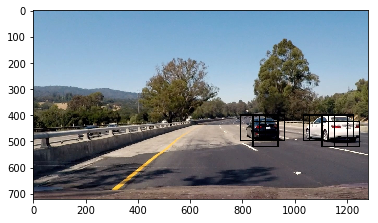

In [7]:
# code
ystart = 400
ystop = 720
scale = 1.5

if(hog_channel == "ALL"):
    #filename = './large_data_alltrain.joblib.pkl'
    pickle_parameters_n = pickle.load( open( "model_trained.p", "rb" ) ) 
    svc2 = pickle_parameters_n["svc"]
else:
    filename = './large_data_train.joblib.pkl'
    svc2 = joblib.load(filename)

X_scaler = pickle_parameters_n["X_scaler"]
im = mpimg.imread("./test_images/test4.jpg").astype(np.float32)/255
out_img, car_boxes = find_cars(im, ystart, ystop, scale, svc2, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,hog_channel)



plt.imshow(out_img)


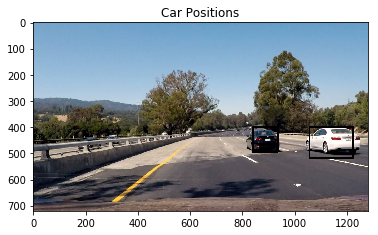

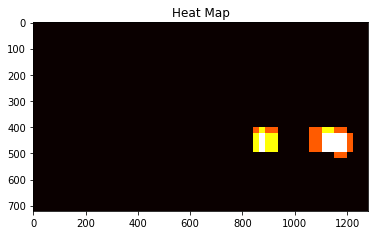

In [19]:

from scipy.ndimage.measurements import label
# Add heat to each box in box list
heat = np.zeros_like(out_img[:,:,0]).astype(np.float)
heat = add_heat(heat,car_boxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(im), labels)


fig = plt.figure()
#plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.show()
#plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Test on Videos


In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


### Pipeline to process the images from video

In [21]:
def process_image(image):
    im = image.astype(np.float32)/255
    out_img, car_boxes = find_cars(im, ystart, ystop, scale, svc2, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,hog_channel)

    #Circle the cars on centroid
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,car_boxes)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img


Let's try the one with the solid white lane on the right first ...

In [24]:
#Video Processing
#clip1 = VideoFileClip("test_video.mp4")#.subclip(38,43)
#white_output = 'm_out_test_video.mp4'

clip1 = VideoFileClip("project_video.mp4")
white_output = 'out_project_video.mp4'

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


size:::: 6108
[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

size:::: 6108


  0%|          | 1/1261 [00:00<13:33,  1.55it/s]

size:::: 6108


  0%|          | 2/1261 [00:01<13:20,  1.57it/s]

size:::: 6108


  0%|          | 3/1261 [00:01<13:14,  1.58it/s]

size:::: 6108


  0%|          | 4/1261 [00:02<13:18,  1.57it/s]

size:::: 6108


  0%|          | 5/1261 [00:03<13:13,  1.58it/s]

size:::: 6108


  0%|          | 6/1261 [00:03<13:19,  1.57it/s]

size:::: 6108


  1%|          | 7/1261 [00:04<13:44,  1.52it/s]

size:::: 6108


  1%|          | 8/1261 [00:05<13:35,  1.54it/s]

size:::: 6108


  1%|          | 9/1261 [00:05<13:22,  1.56it/s]

size:::: 6108


  1%|          | 10/1261 [00:06<13:12,  1.58it/s]

size:::: 6108


  1%|          | 11/1261 [00:07<13:19,  1.56it/s]

size:::: 6108


  1%|          | 12/1261 [00:07<14:01,  1.49it/s]

size:::: 6108


  1%|          | 13/1261 [00:08<13:56,  1.49it/s]

size:::: 6108


  1%|          | 14/1261 [00:09<14:13,  1.46it/s]

size:::: 6108


  1%|          | 15/1261 [00:09<14:10,  1.47it/s]

size:::: 6108


  1%|▏         | 16/1261 [00:10<14:00,  1.48it/s]

size:::: 6108


  1%|▏         | 17/1261 [00:11<13:50,  1.50it/s]

size:::: 6108


  1%|▏         | 18/1261 [00:11<13:47,  1.50it/s]

size:::: 6108


  2%|▏         | 19/1261 [00:12<13:28,  1.54it/s]

size:::: 6108


  2%|▏         | 20/1261 [00:13<13:20,  1.55it/s]

size:::: 6108


  2%|▏         | 21/1261 [00:13<13:10,  1.57it/s]

size:::: 6108


  2%|▏         | 22/1261 [00:14<13:36,  1.52it/s]

size:::: 6108


  2%|▏         | 23/1261 [00:15<13:39,  1.51it/s]

size:::: 6108


  2%|▏         | 24/1261 [00:15<14:28,  1.42it/s]

size:::: 6108


  2%|▏         | 25/1261 [00:16<14:31,  1.42it/s]

size:::: 6108


  2%|▏         | 26/1261 [00:17<14:21,  1.43it/s]

size:::: 6108


  2%|▏         | 27/1261 [00:18<15:19,  1.34it/s]

size:::: 6108


  2%|▏         | 28/1261 [00:18<15:15,  1.35it/s]

size:::: 6108


  2%|▏         | 29/1261 [00:19<16:00,  1.28it/s]

size:::: 6108


  2%|▏         | 30/1261 [00:20<15:46,  1.30it/s]

size:::: 6108


  2%|▏         | 31/1261 [00:21<15:06,  1.36it/s]

size:::: 6108


  3%|▎         | 32/1261 [00:21<14:22,  1.43it/s]

size:::: 6108


  3%|▎         | 33/1261 [00:22<13:47,  1.48it/s]

size:::: 6108


  3%|▎         | 34/1261 [00:22<13:24,  1.53it/s]

size:::: 6108


  3%|▎         | 35/1261 [00:23<13:11,  1.55it/s]

size:::: 6108


  3%|▎         | 36/1261 [00:24<12:59,  1.57it/s]

size:::: 6108


  3%|▎         | 37/1261 [00:24<12:50,  1.59it/s]

size:::: 6108


  3%|▎         | 38/1261 [00:25<12:44,  1.60it/s]

size:::: 6108


  3%|▎         | 39/1261 [00:26<12:39,  1.61it/s]

size:::: 6108


  3%|▎         | 40/1261 [00:26<12:38,  1.61it/s]

size:::: 6108


  3%|▎         | 41/1261 [00:27<12:30,  1.62it/s]

size:::: 6108


  3%|▎         | 42/1261 [00:27<12:29,  1.63it/s]

size:::: 6108


  3%|▎         | 43/1261 [00:28<12:40,  1.60it/s]

size:::: 6108


  3%|▎         | 44/1261 [00:29<12:39,  1.60it/s]

size:::: 6108


  4%|▎         | 45/1261 [00:29<12:38,  1.60it/s]

size:::: 6108


  4%|▎         | 46/1261 [00:30<12:38,  1.60it/s]

size:::: 6108


  4%|▎         | 47/1261 [00:31<12:37,  1.60it/s]

size:::: 6108


  4%|▍         | 48/1261 [00:31<12:40,  1.59it/s]

size:::: 6108


  4%|▍         | 49/1261 [00:32<12:40,  1.59it/s]

size:::: 6108


  4%|▍         | 50/1261 [00:32<12:34,  1.61it/s]

size:::: 6108


  4%|▍         | 51/1261 [00:33<12:35,  1.60it/s]

size:::: 6108


  4%|▍         | 52/1261 [00:34<12:34,  1.60it/s]

size:::: 6108


  4%|▍         | 53/1261 [00:34<12:32,  1.61it/s]

size:::: 6108


  4%|▍         | 54/1261 [00:35<12:30,  1.61it/s]

size:::: 6108


  4%|▍         | 55/1261 [00:35<12:26,  1.62it/s]

size:::: 6108


  4%|▍         | 56/1261 [00:36<12:25,  1.62it/s]

size:::: 6108


  5%|▍         | 57/1261 [00:37<12:36,  1.59it/s]

size:::: 6108


  5%|▍         | 58/1261 [00:37<12:40,  1.58it/s]

size:::: 6108


  5%|▍         | 59/1261 [00:38<12:42,  1.58it/s]

size:::: 6108


  5%|▍         | 60/1261 [00:39<12:51,  1.56it/s]

size:::: 6108


  5%|▍         | 61/1261 [00:39<12:48,  1.56it/s]

size:::: 6108


  5%|▍         | 62/1261 [00:40<12:41,  1.58it/s]

size:::: 6108


  5%|▍         | 63/1261 [00:41<12:39,  1.58it/s]

size:::: 6108


  5%|▌         | 64/1261 [00:41<12:31,  1.59it/s]

size:::: 6108


  5%|▌         | 65/1261 [00:42<12:34,  1.59it/s]

size:::: 6108


  5%|▌         | 66/1261 [00:42<12:37,  1.58it/s]

size:::: 6108


  5%|▌         | 67/1261 [00:43<12:43,  1.56it/s]

size:::: 6108


  5%|▌         | 68/1261 [00:44<12:37,  1.57it/s]

size:::: 6108


  5%|▌         | 69/1261 [00:44<12:41,  1.57it/s]

size:::: 6108


  6%|▌         | 70/1261 [00:45<12:33,  1.58it/s]

size:::: 6108


  6%|▌         | 71/1261 [00:46<12:30,  1.58it/s]

size:::: 6108


  6%|▌         | 72/1261 [00:46<12:22,  1.60it/s]

size:::: 6108


  6%|▌         | 73/1261 [00:47<12:21,  1.60it/s]

size:::: 6108


  6%|▌         | 74/1261 [00:48<12:25,  1.59it/s]

size:::: 6108


  6%|▌         | 75/1261 [00:48<12:23,  1.60it/s]

size:::: 6108


  6%|▌         | 76/1261 [00:49<12:20,  1.60it/s]

size:::: 6108


  6%|▌         | 77/1261 [00:49<12:18,  1.60it/s]

size:::: 6108


  6%|▌         | 78/1261 [00:50<12:15,  1.61it/s]

size:::: 6108


  6%|▋         | 79/1261 [00:51<12:14,  1.61it/s]

size:::: 6108


  6%|▋         | 80/1261 [00:51<12:13,  1.61it/s]

size:::: 6108


  6%|▋         | 81/1261 [00:52<12:12,  1.61it/s]

size:::: 6108


  7%|▋         | 82/1261 [00:52<12:09,  1.62it/s]

size:::: 6108


  7%|▋         | 83/1261 [00:53<12:10,  1.61it/s]

size:::: 6108


  7%|▋         | 84/1261 [00:54<12:11,  1.61it/s]

size:::: 6108


  7%|▋         | 85/1261 [00:54<12:07,  1.62it/s]

size:::: 6108


  7%|▋         | 86/1261 [00:55<12:05,  1.62it/s]

size:::: 6108


  7%|▋         | 87/1261 [00:56<12:07,  1.61it/s]

size:::: 6108


  7%|▋         | 88/1261 [00:56<12:10,  1.61it/s]

size:::: 6108


  7%|▋         | 89/1261 [00:57<12:12,  1.60it/s]

size:::: 6108


  7%|▋         | 90/1261 [00:57<12:14,  1.59it/s]

size:::: 6108


  7%|▋         | 91/1261 [00:58<12:29,  1.56it/s]

size:::: 6108


  7%|▋         | 92/1261 [00:59<12:29,  1.56it/s]

size:::: 6108


  7%|▋         | 93/1261 [00:59<12:22,  1.57it/s]

size:::: 6108


  7%|▋         | 94/1261 [01:00<12:34,  1.55it/s]

size:::: 6108


  8%|▊         | 95/1261 [01:01<12:51,  1.51it/s]

size:::: 6108


  8%|▊         | 96/1261 [01:01<13:04,  1.48it/s]

size:::: 6108


  8%|▊         | 97/1261 [01:02<13:43,  1.41it/s]

size:::: 6108


  8%|▊         | 98/1261 [01:03<14:03,  1.38it/s]

size:::: 6108


  8%|▊         | 99/1261 [01:04<14:05,  1.37it/s]

size:::: 6108


  8%|▊         | 100/1261 [01:05<15:21,  1.26it/s]

size:::: 6108


  8%|▊         | 101/1261 [01:06<15:44,  1.23it/s]

size:::: 6108


  8%|▊         | 102/1261 [01:07<16:48,  1.15it/s]

size:::: 6108


  8%|▊         | 103/1261 [01:08<17:35,  1.10it/s]

size:::: 6108


  8%|▊         | 104/1261 [01:09<17:40,  1.09it/s]

size:::: 6108


  8%|▊         | 105/1261 [01:10<18:09,  1.06it/s]

size:::: 6108


  8%|▊         | 106/1261 [01:10<18:19,  1.05it/s]

size:::: 6108


  8%|▊         | 107/1261 [01:11<17:48,  1.08it/s]

size:::: 6108


  9%|▊         | 108/1261 [01:12<16:45,  1.15it/s]

size:::: 6108


  9%|▊         | 109/1261 [01:13<16:12,  1.18it/s]

size:::: 6108


  9%|▊         | 110/1261 [01:14<16:10,  1.19it/s]

size:::: 6108


  9%|▉         | 111/1261 [01:14<15:26,  1.24it/s]

size:::: 6108


  9%|▉         | 112/1261 [01:15<14:42,  1.30it/s]

size:::: 6108


  9%|▉         | 113/1261 [01:16<14:22,  1.33it/s]

size:::: 6108


  9%|▉         | 114/1261 [01:17<14:22,  1.33it/s]

size:::: 6108


  9%|▉         | 115/1261 [01:17<13:59,  1.36it/s]

size:::: 6108


  9%|▉         | 116/1261 [01:18<13:39,  1.40it/s]

size:::: 6108


  9%|▉         | 117/1261 [01:19<13:25,  1.42it/s]

size:::: 6108


  9%|▉         | 118/1261 [01:19<13:18,  1.43it/s]

size:::: 6108


  9%|▉         | 119/1261 [01:20<13:01,  1.46it/s]

size:::: 6108


 10%|▉         | 120/1261 [01:21<12:42,  1.50it/s]

size:::: 6108


 10%|▉         | 121/1261 [01:21<12:54,  1.47it/s]

size:::: 6108


 10%|▉         | 122/1261 [01:22<12:46,  1.49it/s]

size:::: 6108


 10%|▉         | 123/1261 [01:23<12:33,  1.51it/s]

size:::: 6108


 10%|▉         | 124/1261 [01:23<13:31,  1.40it/s]

size:::: 6108


 10%|▉         | 125/1261 [01:24<13:29,  1.40it/s]

size:::: 6108


 10%|▉         | 126/1261 [01:25<13:49,  1.37it/s]

size:::: 6108


 10%|█         | 127/1261 [01:26<14:18,  1.32it/s]

size:::: 6108


 10%|█         | 128/1261 [01:26<14:18,  1.32it/s]

size:::: 6108


 10%|█         | 129/1261 [01:27<14:22,  1.31it/s]

size:::: 6108


 10%|█         | 130/1261 [01:28<14:11,  1.33it/s]

size:::: 6108


 10%|█         | 131/1261 [01:29<14:55,  1.26it/s]

size:::: 6108


 10%|█         | 132/1261 [01:30<14:16,  1.32it/s]

size:::: 6108


 11%|█         | 133/1261 [01:30<13:51,  1.36it/s]

size:::: 6108


 11%|█         | 134/1261 [01:31<13:29,  1.39it/s]

size:::: 6108


 11%|█         | 135/1261 [01:32<13:51,  1.35it/s]

size:::: 6108


 11%|█         | 136/1261 [01:32<13:46,  1.36it/s]

size:::: 6108


 11%|█         | 137/1261 [01:33<14:25,  1.30it/s]

size:::: 6108


 11%|█         | 138/1261 [01:34<14:32,  1.29it/s]

size:::: 6108


 11%|█         | 139/1261 [01:35<14:14,  1.31it/s]

size:::: 6108


 11%|█         | 140/1261 [01:36<15:16,  1.22it/s]

size:::: 6108


 11%|█         | 141/1261 [01:37<15:32,  1.20it/s]

size:::: 6108


 11%|█▏        | 142/1261 [01:37<14:45,  1.26it/s]

size:::: 6108


 11%|█▏        | 143/1261 [01:38<15:21,  1.21it/s]

size:::: 6108


 11%|█▏        | 144/1261 [01:39<14:42,  1.27it/s]

size:::: 6108


 11%|█▏        | 145/1261 [01:40<14:21,  1.30it/s]

size:::: 6108


 12%|█▏        | 146/1261 [01:40<13:41,  1.36it/s]

size:::: 6108


 12%|█▏        | 147/1261 [01:41<13:12,  1.40it/s]

size:::: 6108


 12%|█▏        | 148/1261 [01:42<13:17,  1.39it/s]

size:::: 6108


 12%|█▏        | 149/1261 [01:42<13:27,  1.38it/s]

size:::: 6108


 12%|█▏        | 150/1261 [01:43<13:37,  1.36it/s]

size:::: 6108


 12%|█▏        | 151/1261 [01:44<14:00,  1.32it/s]

size:::: 6108


 12%|█▏        | 152/1261 [01:45<14:38,  1.26it/s]

size:::: 6108


 12%|█▏        | 153/1261 [01:46<15:00,  1.23it/s]

size:::: 6108


 12%|█▏        | 154/1261 [01:47<15:25,  1.20it/s]

size:::: 6108


 12%|█▏        | 155/1261 [01:47<15:12,  1.21it/s]

size:::: 6108


 12%|█▏        | 156/1261 [01:48<14:49,  1.24it/s]

size:::: 6108


 12%|█▏        | 157/1261 [01:49<14:25,  1.28it/s]

size:::: 6108


 13%|█▎        | 158/1261 [01:50<14:43,  1.25it/s]

size:::: 6108


 13%|█▎        | 159/1261 [01:51<14:37,  1.26it/s]

size:::: 6108


 13%|█▎        | 160/1261 [01:51<14:19,  1.28it/s]

size:::: 6108


 13%|█▎        | 161/1261 [01:52<14:21,  1.28it/s]

size:::: 6108


 13%|█▎        | 162/1261 [01:53<14:08,  1.30it/s]

size:::: 6108


 13%|█▎        | 163/1261 [01:54<13:39,  1.34it/s]

size:::: 6108


 13%|█▎        | 164/1261 [01:54<13:23,  1.36it/s]

size:::: 6108


 13%|█▎        | 165/1261 [01:55<14:03,  1.30it/s]

size:::: 6108


 13%|█▎        | 166/1261 [01:56<13:55,  1.31it/s]

size:::: 6108


 13%|█▎        | 167/1261 [01:57<14:01,  1.30it/s]

size:::: 6108


 13%|█▎        | 168/1261 [01:57<14:12,  1.28it/s]

size:::: 6108


 13%|█▎        | 169/1261 [01:58<14:02,  1.30it/s]

size:::: 6108


 13%|█▎        | 170/1261 [01:59<13:58,  1.30it/s]

size:::: 6108


 14%|█▎        | 171/1261 [02:00<14:00,  1.30it/s]

size:::: 6108


 14%|█▎        | 172/1261 [02:00<13:54,  1.31it/s]

size:::: 6108


 14%|█▎        | 173/1261 [02:01<13:09,  1.38it/s]

size:::: 6108


 14%|█▍        | 174/1261 [02:02<12:41,  1.43it/s]

size:::: 6108


 14%|█▍        | 175/1261 [02:02<12:39,  1.43it/s]

size:::: 6108


 14%|█▍        | 176/1261 [02:03<12:32,  1.44it/s]

size:::: 6108


 14%|█▍        | 177/1261 [02:04<12:29,  1.45it/s]

size:::: 6108


 14%|█▍        | 178/1261 [02:04<12:30,  1.44it/s]

size:::: 6108


 14%|█▍        | 179/1261 [02:05<12:13,  1.47it/s]

size:::: 6108


 14%|█▍        | 180/1261 [02:06<12:06,  1.49it/s]

size:::: 6108


 14%|█▍        | 181/1261 [02:06<12:03,  1.49it/s]

size:::: 6108


 14%|█▍        | 182/1261 [02:07<11:55,  1.51it/s]

size:::: 6108


 15%|█▍        | 183/1261 [02:08<11:52,  1.51it/s]

size:::: 6108


 15%|█▍        | 184/1261 [02:08<11:56,  1.50it/s]

size:::: 6108


 15%|█▍        | 185/1261 [02:09<11:50,  1.51it/s]

size:::: 6108


 15%|█▍        | 186/1261 [02:10<11:36,  1.54it/s]

size:::: 6108


 15%|█▍        | 187/1261 [02:10<11:39,  1.54it/s]

size:::: 6108


 15%|█▍        | 188/1261 [02:11<11:35,  1.54it/s]

size:::: 6108


 15%|█▍        | 189/1261 [02:12<11:31,  1.55it/s]

size:::: 6108


 15%|█▌        | 190/1261 [02:12<11:30,  1.55it/s]

size:::: 6108


 15%|█▌        | 191/1261 [02:13<11:32,  1.55it/s]

size:::: 6108


 15%|█▌        | 192/1261 [02:14<11:36,  1.53it/s]

size:::: 6108


 15%|█▌        | 193/1261 [02:14<11:35,  1.53it/s]

size:::: 6108


 15%|█▌        | 194/1261 [02:15<11:33,  1.54it/s]

size:::: 6108


 15%|█▌        | 195/1261 [02:16<11:24,  1.56it/s]

size:::: 6108


 16%|█▌        | 196/1261 [02:16<11:21,  1.56it/s]

size:::: 6108


 16%|█▌        | 197/1261 [02:17<11:20,  1.56it/s]

size:::: 6108


 16%|█▌        | 198/1261 [02:17<11:20,  1.56it/s]

size:::: 6108


 16%|█▌        | 199/1261 [02:18<11:23,  1.55it/s]

size:::: 6108


 16%|█▌        | 200/1261 [02:19<11:18,  1.56it/s]

size:::: 6108


 16%|█▌        | 201/1261 [02:19<11:26,  1.54it/s]

size:::: 6108


 16%|█▌        | 202/1261 [02:20<11:14,  1.57it/s]

size:::: 6108


 16%|█▌        | 203/1261 [02:21<11:24,  1.55it/s]

size:::: 6108


 16%|█▌        | 204/1261 [02:21<11:33,  1.52it/s]

size:::: 6108


 16%|█▋        | 205/1261 [02:22<11:29,  1.53it/s]

size:::: 6108


 16%|█▋        | 206/1261 [02:23<11:29,  1.53it/s]

size:::: 6108


 16%|█▋        | 207/1261 [02:23<11:35,  1.51it/s]

size:::: 6108


 16%|█▋        | 208/1261 [02:24<11:26,  1.53it/s]

size:::: 6108


 17%|█▋        | 209/1261 [02:25<11:31,  1.52it/s]

size:::: 6108


 17%|█▋        | 210/1261 [02:25<11:30,  1.52it/s]

size:::: 6108


 17%|█▋        | 211/1261 [02:26<11:36,  1.51it/s]

size:::: 6108


 17%|█▋        | 212/1261 [02:27<11:34,  1.51it/s]

size:::: 6108


 17%|█▋        | 213/1261 [02:27<11:22,  1.53it/s]

size:::: 6108


 17%|█▋        | 214/1261 [02:28<11:25,  1.53it/s]

size:::: 6108


 17%|█▋        | 215/1261 [02:29<11:30,  1.51it/s]

size:::: 6108


 17%|█▋        | 216/1261 [02:29<11:31,  1.51it/s]

size:::: 6108


 17%|█▋        | 217/1261 [02:30<11:36,  1.50it/s]

size:::: 6108


 17%|█▋        | 218/1261 [02:31<11:23,  1.53it/s]

size:::: 6108


 17%|█▋        | 219/1261 [02:31<11:24,  1.52it/s]

size:::: 6108


 17%|█▋        | 220/1261 [02:32<11:22,  1.53it/s]

size:::: 6108


 18%|█▊        | 221/1261 [02:33<11:25,  1.52it/s]

size:::: 6108


 18%|█▊        | 222/1261 [02:33<11:50,  1.46it/s]

size:::: 6108


 18%|█▊        | 223/1261 [02:34<11:42,  1.48it/s]

size:::: 6108


 18%|█▊        | 224/1261 [02:35<11:39,  1.48it/s]

size:::: 6108


 18%|█▊        | 225/1261 [02:35<11:29,  1.50it/s]

size:::: 6108


 18%|█▊        | 226/1261 [02:36<11:28,  1.50it/s]

size:::: 6108


 18%|█▊        | 227/1261 [02:37<12:09,  1.42it/s]

size:::: 6108


 18%|█▊        | 228/1261 [02:37<12:18,  1.40it/s]

size:::: 6108


 18%|█▊        | 229/1261 [02:38<12:11,  1.41it/s]

size:::: 6108


 18%|█▊        | 230/1261 [02:39<12:07,  1.42it/s]

size:::: 6108


 18%|█▊        | 231/1261 [02:40<12:00,  1.43it/s]

size:::: 6108


 18%|█▊        | 232/1261 [02:40<11:49,  1.45it/s]

size:::: 6108


 18%|█▊        | 233/1261 [02:41<11:36,  1.48it/s]

size:::: 6108


 19%|█▊        | 234/1261 [02:41<11:34,  1.48it/s]

size:::: 6108


 19%|█▊        | 235/1261 [02:42<11:50,  1.44it/s]

size:::: 6108


 19%|█▊        | 236/1261 [02:43<12:12,  1.40it/s]

size:::: 6108


 19%|█▉        | 237/1261 [02:44<12:06,  1.41it/s]

size:::: 6108


 19%|█▉        | 238/1261 [02:44<11:58,  1.42it/s]

size:::: 6108


 19%|█▉        | 239/1261 [02:45<11:55,  1.43it/s]

size:::: 6108


 19%|█▉        | 240/1261 [02:46<11:52,  1.43it/s]

size:::: 6108


 19%|█▉        | 241/1261 [02:46<11:48,  1.44it/s]

size:::: 6108


 19%|█▉        | 242/1261 [02:47<11:43,  1.45it/s]

size:::: 6108


 19%|█▉        | 243/1261 [02:48<11:33,  1.47it/s]

size:::: 6108


 19%|█▉        | 244/1261 [02:48<11:33,  1.47it/s]

size:::: 6108


 19%|█▉        | 245/1261 [02:49<11:19,  1.50it/s]

size:::: 6108


 20%|█▉        | 246/1261 [02:50<11:16,  1.50it/s]

size:::: 6108


 20%|█▉        | 247/1261 [02:50<11:15,  1.50it/s]

size:::: 6108


 20%|█▉        | 248/1261 [02:51<11:20,  1.49it/s]

size:::: 6108


 20%|█▉        | 249/1261 [02:52<11:18,  1.49it/s]

size:::: 6108


 20%|█▉        | 250/1261 [02:52<11:14,  1.50it/s]

size:::: 6108


 20%|█▉        | 251/1261 [02:53<11:12,  1.50it/s]

size:::: 6108


 20%|█▉        | 252/1261 [02:54<11:11,  1.50it/s]

size:::: 6108


 20%|██        | 253/1261 [02:54<11:19,  1.48it/s]

size:::: 6108


 20%|██        | 254/1261 [02:55<11:15,  1.49it/s]

size:::: 6108


 20%|██        | 255/1261 [02:56<11:09,  1.50it/s]

size:::: 6108


 20%|██        | 256/1261 [02:56<11:17,  1.48it/s]

size:::: 6108


 20%|██        | 257/1261 [02:57<11:08,  1.50it/s]

size:::: 6108


 20%|██        | 258/1261 [02:58<11:09,  1.50it/s]

size:::: 6108


 21%|██        | 259/1261 [02:58<11:02,  1.51it/s]

size:::: 6108


 21%|██        | 260/1261 [02:59<10:58,  1.52it/s]

size:::: 6108


 21%|██        | 261/1261 [03:00<11:06,  1.50it/s]

size:::: 6108


 21%|██        | 262/1261 [03:00<11:11,  1.49it/s]

size:::: 6108


 21%|██        | 263/1261 [03:01<11:16,  1.47it/s]

size:::: 6108


 21%|██        | 264/1261 [03:02<11:19,  1.47it/s]

size:::: 6108


 21%|██        | 265/1261 [03:03<11:16,  1.47it/s]

size:::: 6108


 21%|██        | 266/1261 [03:03<11:09,  1.49it/s]

size:::: 6108


 21%|██        | 267/1261 [03:04<10:59,  1.51it/s]

size:::: 6108


 21%|██▏       | 268/1261 [03:05<11:09,  1.48it/s]

size:::: 6108


 21%|██▏       | 269/1261 [03:05<11:10,  1.48it/s]

size:::: 6108


 21%|██▏       | 270/1261 [03:06<11:06,  1.49it/s]

size:::: 6108


 21%|██▏       | 271/1261 [03:07<10:55,  1.51it/s]

size:::: 6108


 22%|██▏       | 272/1261 [03:07<10:54,  1.51it/s]

size:::: 6108


 22%|██▏       | 273/1261 [03:08<10:57,  1.50it/s]

size:::: 6108


 22%|██▏       | 274/1261 [03:09<11:26,  1.44it/s]

size:::: 6108


 22%|██▏       | 275/1261 [03:09<11:14,  1.46it/s]

size:::: 6108


 22%|██▏       | 276/1261 [03:10<11:16,  1.46it/s]

size:::: 6108


 22%|██▏       | 277/1261 [03:11<11:14,  1.46it/s]

size:::: 6108


 22%|██▏       | 278/1261 [03:11<11:18,  1.45it/s]

size:::: 6108


 22%|██▏       | 279/1261 [03:12<11:08,  1.47it/s]

size:::: 6108


 22%|██▏       | 280/1261 [03:13<11:05,  1.47it/s]

size:::: 6108


 22%|██▏       | 281/1261 [03:13<10:57,  1.49it/s]

size:::: 6108


 22%|██▏       | 282/1261 [03:14<10:53,  1.50it/s]

size:::: 6108


 22%|██▏       | 283/1261 [03:15<10:50,  1.50it/s]

size:::: 6108


 23%|██▎       | 284/1261 [03:15<10:47,  1.51it/s]

size:::: 6108


 23%|██▎       | 285/1261 [03:16<10:48,  1.51it/s]

size:::: 6108


 23%|██▎       | 286/1261 [03:17<10:50,  1.50it/s]

size:::: 6108


 23%|██▎       | 287/1261 [03:17<10:45,  1.51it/s]

size:::: 6108


 23%|██▎       | 288/1261 [03:18<10:49,  1.50it/s]

size:::: 6108


 23%|██▎       | 289/1261 [03:19<10:45,  1.51it/s]

size:::: 6108


 23%|██▎       | 290/1261 [03:19<10:51,  1.49it/s]

size:::: 6108


 23%|██▎       | 291/1261 [03:20<10:57,  1.48it/s]

size:::: 6108


 23%|██▎       | 292/1261 [03:21<11:01,  1.46it/s]

size:::: 6108


 23%|██▎       | 293/1261 [03:21<10:59,  1.47it/s]

size:::: 6108


 23%|██▎       | 294/1261 [03:22<10:52,  1.48it/s]

size:::: 6108


 23%|██▎       | 295/1261 [03:23<10:44,  1.50it/s]

size:::: 6108


 23%|██▎       | 296/1261 [03:23<10:42,  1.50it/s]

size:::: 6108


 24%|██▎       | 297/1261 [03:24<10:41,  1.50it/s]

size:::: 6108


 24%|██▎       | 298/1261 [03:25<10:47,  1.49it/s]

size:::: 6108


 24%|██▎       | 299/1261 [03:25<10:48,  1.48it/s]

size:::: 6108


 24%|██▍       | 300/1261 [03:26<10:51,  1.47it/s]

size:::: 6108


 24%|██▍       | 301/1261 [03:27<10:41,  1.50it/s]

size:::: 6108


 24%|██▍       | 302/1261 [03:27<10:41,  1.49it/s]

size:::: 6108


 24%|██▍       | 303/1261 [03:28<10:43,  1.49it/s]

size:::: 6108


 24%|██▍       | 304/1261 [03:29<10:39,  1.50it/s]

size:::: 6108


 24%|██▍       | 305/1261 [03:29<10:50,  1.47it/s]

size:::: 6108


 24%|██▍       | 306/1261 [03:30<10:54,  1.46it/s]

size:::: 6108


 24%|██▍       | 307/1261 [03:31<10:49,  1.47it/s]

size:::: 6108


 24%|██▍       | 308/1261 [03:32<11:28,  1.38it/s]

size:::: 6108


 25%|██▍       | 309/1261 [03:32<11:46,  1.35it/s]

size:::: 6108


 25%|██▍       | 310/1261 [03:33<12:50,  1.23it/s]

size:::: 6108


 25%|██▍       | 311/1261 [03:34<13:38,  1.16it/s]

size:::: 6108


 25%|██▍       | 312/1261 [03:35<12:55,  1.22it/s]

size:::: 6108


 25%|██▍       | 313/1261 [03:36<12:08,  1.30it/s]

size:::: 6108


 25%|██▍       | 314/1261 [03:36<11:47,  1.34it/s]

size:::: 6108


 25%|██▍       | 315/1261 [03:37<11:33,  1.36it/s]

size:::: 6108


 25%|██▌       | 316/1261 [03:38<11:33,  1.36it/s]

size:::: 6108


 25%|██▌       | 317/1261 [03:39<11:27,  1.37it/s]

size:::: 6108


 25%|██▌       | 318/1261 [03:39<11:43,  1.34it/s]

size:::: 6108


 25%|██▌       | 319/1261 [03:40<11:26,  1.37it/s]

size:::: 6108


 25%|██▌       | 320/1261 [03:41<11:09,  1.41it/s]

size:::: 6108


 25%|██▌       | 321/1261 [03:42<11:38,  1.35it/s]

size:::: 6108


 26%|██▌       | 322/1261 [03:42<12:11,  1.28it/s]

size:::: 6108


 26%|██▌       | 323/1261 [03:43<12:22,  1.26it/s]

size:::: 6108


 26%|██▌       | 324/1261 [03:44<11:54,  1.31it/s]

size:::: 6108


 26%|██▌       | 325/1261 [03:45<12:44,  1.22it/s]

size:::: 6108


 26%|██▌       | 326/1261 [03:46<13:06,  1.19it/s]

size:::: 6108


 26%|██▌       | 327/1261 [03:47<13:37,  1.14it/s]

size:::: 6108


 26%|██▌       | 328/1261 [03:48<13:12,  1.18it/s]

size:::: 6108


 26%|██▌       | 329/1261 [03:48<13:09,  1.18it/s]

size:::: 6108


 26%|██▌       | 330/1261 [03:49<13:00,  1.19it/s]

size:::: 6108


 26%|██▌       | 331/1261 [03:50<14:21,  1.08it/s]

size:::: 6108


 26%|██▋       | 332/1261 [03:51<14:26,  1.07it/s]

size:::: 6108


 26%|██▋       | 333/1261 [03:52<13:56,  1.11it/s]

size:::: 6108


 26%|██▋       | 334/1261 [03:53<13:42,  1.13it/s]

size:::: 6108


 27%|██▋       | 335/1261 [03:54<13:19,  1.16it/s]

size:::: 6108


 27%|██▋       | 336/1261 [03:54<12:23,  1.24it/s]

size:::: 6108


 27%|██▋       | 337/1261 [03:55<11:55,  1.29it/s]

size:::: 6108


 27%|██▋       | 338/1261 [03:56<11:24,  1.35it/s]

size:::: 6108


 27%|██▋       | 339/1261 [03:57<12:22,  1.24it/s]

size:::: 6108


 27%|██▋       | 340/1261 [03:57<11:51,  1.29it/s]

size:::: 6108


 27%|██▋       | 341/1261 [03:58<11:25,  1.34it/s]

size:::: 6108


 27%|██▋       | 342/1261 [03:59<11:04,  1.38it/s]

size:::: 6108


 27%|██▋       | 343/1261 [03:59<10:58,  1.39it/s]

size:::: 6108


 27%|██▋       | 344/1261 [04:00<10:54,  1.40it/s]

size:::: 6108


 27%|██▋       | 345/1261 [04:01<10:30,  1.45it/s]

size:::: 6108


 27%|██▋       | 346/1261 [04:01<10:25,  1.46it/s]

size:::: 6108


 28%|██▊       | 347/1261 [04:02<10:21,  1.47it/s]

size:::: 6108


 28%|██▊       | 348/1261 [04:03<10:16,  1.48it/s]

size:::: 6108


 28%|██▊       | 349/1261 [04:04<10:26,  1.46it/s]

size:::: 6108


 28%|██▊       | 350/1261 [04:04<11:04,  1.37it/s]

size:::: 6108


 28%|██▊       | 351/1261 [04:05<11:47,  1.29it/s]

size:::: 6108


 28%|██▊       | 352/1261 [04:06<11:51,  1.28it/s]

size:::: 6108


 28%|██▊       | 353/1261 [04:07<11:59,  1.26it/s]

size:::: 6108


 28%|██▊       | 354/1261 [04:08<12:12,  1.24it/s]

size:::: 6108


 28%|██▊       | 355/1261 [04:09<12:30,  1.21it/s]

size:::: 6108


 28%|██▊       | 356/1261 [04:10<13:01,  1.16it/s]

size:::: 6108


 28%|██▊       | 357/1261 [04:11<13:29,  1.12it/s]

size:::: 6108


 28%|██▊       | 358/1261 [04:11<13:27,  1.12it/s]

size:::: 6108


 28%|██▊       | 359/1261 [04:12<13:14,  1.14it/s]

size:::: 6108


 29%|██▊       | 360/1261 [04:13<13:30,  1.11it/s]

size:::: 6108


 29%|██▊       | 361/1261 [04:14<13:23,  1.12it/s]

size:::: 6108


 29%|██▊       | 362/1261 [04:15<13:06,  1.14it/s]

size:::: 6108


 29%|██▉       | 363/1261 [04:16<12:17,  1.22it/s]

size:::: 6108


 29%|██▉       | 364/1261 [04:16<11:45,  1.27it/s]

size:::: 6108


 29%|██▉       | 365/1261 [04:17<12:03,  1.24it/s]

size:::: 6108


 29%|██▉       | 366/1261 [04:18<12:11,  1.22it/s]

size:::: 6108


 29%|██▉       | 367/1261 [04:19<12:06,  1.23it/s]

size:::: 6108


 29%|██▉       | 368/1261 [04:20<11:45,  1.27it/s]

size:::: 6108


 29%|██▉       | 369/1261 [04:20<11:49,  1.26it/s]

size:::: 6108


 29%|██▉       | 370/1261 [04:21<11:38,  1.28it/s]

size:::: 6108


 29%|██▉       | 371/1261 [04:22<11:53,  1.25it/s]

size:::: 6108


 30%|██▉       | 372/1261 [04:23<12:10,  1.22it/s]

size:::: 6108


 30%|██▉       | 373/1261 [04:24<12:07,  1.22it/s]

size:::: 6108


 30%|██▉       | 374/1261 [04:24<12:04,  1.22it/s]

size:::: 6108


 30%|██▉       | 375/1261 [04:25<11:36,  1.27it/s]

size:::: 6108


 30%|██▉       | 376/1261 [04:26<11:33,  1.28it/s]

size:::: 6108


 30%|██▉       | 377/1261 [04:27<11:30,  1.28it/s]

size:::: 6108


 30%|██▉       | 378/1261 [04:27<11:28,  1.28it/s]

size:::: 6108


 30%|███       | 379/1261 [04:28<11:06,  1.32it/s]

size:::: 6108


 30%|███       | 380/1261 [04:29<10:53,  1.35it/s]

size:::: 6108


 30%|███       | 381/1261 [04:30<10:47,  1.36it/s]

size:::: 6108


 30%|███       | 382/1261 [04:30<11:04,  1.32it/s]

size:::: 6108


 30%|███       | 383/1261 [04:31<10:54,  1.34it/s]

size:::: 6108


 30%|███       | 384/1261 [04:32<11:02,  1.32it/s]

size:::: 6108


 31%|███       | 385/1261 [04:33<11:07,  1.31it/s]

size:::: 6108


 31%|███       | 386/1261 [04:33<11:15,  1.30it/s]

size:::: 6108


 31%|███       | 387/1261 [04:34<11:16,  1.29it/s]

size:::: 6108


 31%|███       | 388/1261 [04:35<11:38,  1.25it/s]

size:::: 6108


 31%|███       | 389/1261 [04:36<11:53,  1.22it/s]

size:::: 6108


 31%|███       | 390/1261 [04:37<11:38,  1.25it/s]

size:::: 6108


 31%|███       | 391/1261 [04:37<11:22,  1.27it/s]

size:::: 6108


 31%|███       | 392/1261 [04:38<11:14,  1.29it/s]

size:::: 6108


 31%|███       | 393/1261 [04:39<10:55,  1.32it/s]

size:::: 6108


 31%|███       | 394/1261 [04:40<11:31,  1.25it/s]

size:::: 6108


 31%|███▏      | 395/1261 [04:41<11:44,  1.23it/s]

size:::: 6108


 31%|███▏      | 396/1261 [04:42<12:07,  1.19it/s]

size:::: 6108


 31%|███▏      | 397/1261 [04:42<12:07,  1.19it/s]

size:::: 6108


 32%|███▏      | 398/1261 [04:43<12:08,  1.18it/s]

size:::: 6108


 32%|███▏      | 399/1261 [04:44<11:57,  1.20it/s]

size:::: 6108


 32%|███▏      | 400/1261 [04:45<12:18,  1.17it/s]

size:::: 6108


 32%|███▏      | 401/1261 [04:46<12:02,  1.19it/s]

size:::: 6108


 32%|███▏      | 402/1261 [04:47<12:07,  1.18it/s]

size:::: 6108


 32%|███▏      | 403/1261 [04:48<12:05,  1.18it/s]

size:::: 6108


 32%|███▏      | 404/1261 [04:48<12:05,  1.18it/s]

size:::: 6108


 32%|███▏      | 405/1261 [04:49<11:55,  1.20it/s]

size:::: 6108


 32%|███▏      | 406/1261 [04:50<11:50,  1.20it/s]

size:::: 6108


 32%|███▏      | 407/1261 [04:51<11:54,  1.20it/s]

size:::: 6108


 32%|███▏      | 408/1261 [04:52<11:58,  1.19it/s]

size:::: 6108


 32%|███▏      | 409/1261 [04:53<11:59,  1.18it/s]

size:::: 6108


 33%|███▎      | 410/1261 [04:53<12:02,  1.18it/s]

size:::: 6108


 33%|███▎      | 411/1261 [04:54<12:03,  1.18it/s]

size:::: 6108


 33%|███▎      | 412/1261 [04:55<12:01,  1.18it/s]

size:::: 6108


 33%|███▎      | 413/1261 [04:56<11:53,  1.19it/s]

size:::: 6108


 33%|███▎      | 414/1261 [04:57<11:53,  1.19it/s]

size:::: 6108


 33%|███▎      | 415/1261 [04:58<11:43,  1.20it/s]

size:::: 6108


 33%|███▎      | 416/1261 [04:58<11:31,  1.22it/s]

size:::: 6108


 33%|███▎      | 417/1261 [04:59<11:24,  1.23it/s]

size:::: 6108


 33%|███▎      | 418/1261 [05:00<11:21,  1.24it/s]

size:::: 6108


 33%|███▎      | 419/1261 [05:01<11:27,  1.22it/s]

size:::: 6108


 33%|███▎      | 420/1261 [05:02<11:31,  1.22it/s]

size:::: 6108


 33%|███▎      | 421/1261 [05:02<11:25,  1.22it/s]

size:::: 6108


 33%|███▎      | 422/1261 [05:03<11:33,  1.21it/s]

size:::: 6108


 34%|███▎      | 423/1261 [05:04<11:32,  1.21it/s]

size:::: 6108


 34%|███▎      | 424/1261 [05:05<11:32,  1.21it/s]

size:::: 6108


 34%|███▎      | 425/1261 [05:06<11:34,  1.20it/s]

size:::: 6108


 34%|███▍      | 426/1261 [05:07<11:39,  1.19it/s]

size:::: 6108


 34%|███▍      | 427/1261 [05:07<11:30,  1.21it/s]

size:::: 6108


 34%|███▍      | 428/1261 [05:08<11:36,  1.20it/s]

size:::: 6108


 34%|███▍      | 429/1261 [05:09<12:12,  1.14it/s]

size:::: 6108


 34%|███▍      | 430/1261 [05:10<12:07,  1.14it/s]

size:::: 6108


 34%|███▍      | 431/1261 [05:11<11:56,  1.16it/s]

size:::: 6108


 34%|███▍      | 432/1261 [05:12<11:57,  1.15it/s]

size:::: 6108


 34%|███▍      | 433/1261 [05:13<12:04,  1.14it/s]

size:::: 6108


 34%|███▍      | 434/1261 [05:14<11:52,  1.16it/s]

size:::: 6108


 34%|███▍      | 435/1261 [05:14<11:56,  1.15it/s]

size:::: 6108


 35%|███▍      | 436/1261 [05:15<11:47,  1.17it/s]

size:::: 6108


 35%|███▍      | 437/1261 [05:16<11:34,  1.19it/s]

size:::: 6108


 35%|███▍      | 438/1261 [05:17<11:32,  1.19it/s]

size:::: 6108


 35%|███▍      | 439/1261 [05:18<11:26,  1.20it/s]

size:::: 6108


 35%|███▍      | 440/1261 [05:19<11:21,  1.20it/s]

size:::: 6108


 35%|███▍      | 441/1261 [05:19<11:14,  1.22it/s]

size:::: 6108


 35%|███▌      | 442/1261 [05:20<11:29,  1.19it/s]

size:::: 6108


 35%|███▌      | 443/1261 [05:21<11:32,  1.18it/s]

size:::: 6108


 35%|███▌      | 444/1261 [05:22<11:28,  1.19it/s]

size:::: 6108


 35%|███▌      | 445/1261 [05:23<11:11,  1.22it/s]

size:::: 6108


 35%|███▌      | 446/1261 [05:24<11:07,  1.22it/s]

size:::: 6108


 35%|███▌      | 447/1261 [05:24<11:13,  1.21it/s]

size:::: 6108


 36%|███▌      | 448/1261 [05:25<11:06,  1.22it/s]

size:::: 6108


 36%|███▌      | 449/1261 [05:26<10:46,  1.26it/s]

size:::: 6108


 36%|███▌      | 450/1261 [05:27<10:58,  1.23it/s]

size:::: 6108


 36%|███▌      | 451/1261 [05:28<11:13,  1.20it/s]

size:::: 6108


 36%|███▌      | 452/1261 [05:29<11:24,  1.18it/s]

size:::: 6108


 36%|███▌      | 453/1261 [05:29<11:09,  1.21it/s]

size:::: 6108


 36%|███▌      | 454/1261 [05:30<10:45,  1.25it/s]

size:::: 6108


 36%|███▌      | 455/1261 [05:31<10:31,  1.28it/s]

size:::: 6108


 36%|███▌      | 456/1261 [05:32<10:28,  1.28it/s]

size:::: 6108


 36%|███▌      | 457/1261 [05:32<10:40,  1.26it/s]

size:::: 6108


 36%|███▋      | 458/1261 [05:33<10:43,  1.25it/s]

size:::: 6108


 36%|███▋      | 459/1261 [05:34<10:33,  1.27it/s]

size:::: 6108


 36%|███▋      | 460/1261 [05:35<10:30,  1.27it/s]

size:::: 6108


 37%|███▋      | 461/1261 [05:36<10:26,  1.28it/s]

size:::: 6108


 37%|███▋      | 462/1261 [05:36<10:28,  1.27it/s]

size:::: 6108


 37%|███▋      | 463/1261 [05:37<10:42,  1.24it/s]

size:::: 6108


 37%|███▋      | 464/1261 [05:38<11:01,  1.21it/s]

size:::: 6108


 37%|███▋      | 465/1261 [05:39<11:03,  1.20it/s]

size:::: 6108


 37%|███▋      | 466/1261 [05:40<10:55,  1.21it/s]

size:::: 6108


 37%|███▋      | 467/1261 [05:40<10:39,  1.24it/s]

size:::: 6108


 37%|███▋      | 468/1261 [05:41<10:21,  1.28it/s]

size:::: 6108


 37%|███▋      | 469/1261 [05:42<10:04,  1.31it/s]

size:::: 6108


 37%|███▋      | 470/1261 [05:43<10:22,  1.27it/s]

size:::: 6108


 37%|███▋      | 471/1261 [05:44<10:10,  1.29it/s]

size:::: 6108


 37%|███▋      | 472/1261 [05:44<10:03,  1.31it/s]

size:::: 6108


 38%|███▊      | 473/1261 [05:45<10:03,  1.31it/s]

size:::: 6108


 38%|███▊      | 474/1261 [05:46<09:56,  1.32it/s]

size:::: 6108


 38%|███▊      | 475/1261 [05:46<09:44,  1.34it/s]

size:::: 6108


 38%|███▊      | 476/1261 [05:47<09:37,  1.36it/s]

size:::: 6108


 38%|███▊      | 477/1261 [05:48<10:13,  1.28it/s]

size:::: 6108


 38%|███▊      | 478/1261 [05:49<10:32,  1.24it/s]

size:::: 6108


 38%|███▊      | 479/1261 [05:50<10:44,  1.21it/s]

size:::: 6108


 38%|███▊      | 480/1261 [05:51<10:53,  1.20it/s]

size:::: 6108


 38%|███▊      | 481/1261 [05:51<10:27,  1.24it/s]

size:::: 6108


 38%|███▊      | 482/1261 [05:52<10:14,  1.27it/s]

size:::: 6108


 38%|███▊      | 483/1261 [05:53<09:56,  1.30it/s]

size:::: 6108


 38%|███▊      | 484/1261 [05:54<09:41,  1.34it/s]

size:::: 6108


 38%|███▊      | 485/1261 [05:54<09:31,  1.36it/s]

size:::: 6108


 39%|███▊      | 486/1261 [05:55<09:26,  1.37it/s]

size:::: 6108


 39%|███▊      | 487/1261 [05:56<09:28,  1.36it/s]

size:::: 6108


 39%|███▊      | 488/1261 [05:56<09:23,  1.37it/s]

size:::: 6108


 39%|███▉      | 489/1261 [05:57<09:19,  1.38it/s]

size:::: 6108


 39%|███▉      | 490/1261 [05:58<09:19,  1.38it/s]

size:::: 6108


 39%|███▉      | 491/1261 [05:59<09:14,  1.39it/s]

size:::: 6108


 39%|███▉      | 492/1261 [05:59<09:11,  1.40it/s]

size:::: 6108


 39%|███▉      | 493/1261 [06:00<09:20,  1.37it/s]

size:::: 6108


 39%|███▉      | 494/1261 [06:01<09:31,  1.34it/s]

size:::: 6108


 39%|███▉      | 495/1261 [06:02<09:30,  1.34it/s]

size:::: 6108


 39%|███▉      | 496/1261 [06:02<09:43,  1.31it/s]

size:::: 6108


 39%|███▉      | 497/1261 [06:03<09:47,  1.30it/s]

size:::: 6108


 39%|███▉      | 498/1261 [06:04<09:30,  1.34it/s]

size:::: 6108


 40%|███▉      | 499/1261 [06:05<09:21,  1.36it/s]

size:::: 6108


 40%|███▉      | 500/1261 [06:05<09:26,  1.34it/s]

size:::: 6108


 40%|███▉      | 501/1261 [06:06<09:20,  1.36it/s]

size:::: 6108


 40%|███▉      | 502/1261 [06:07<09:14,  1.37it/s]

size:::: 6108


 40%|███▉      | 503/1261 [06:08<09:13,  1.37it/s]

size:::: 6108


 40%|███▉      | 504/1261 [06:08<09:56,  1.27it/s]

size:::: 6108


 40%|████      | 505/1261 [06:09<10:19,  1.22it/s]

size:::: 6108


 40%|████      | 506/1261 [06:10<10:29,  1.20it/s]

size:::: 6108


 40%|████      | 507/1261 [06:11<10:07,  1.24it/s]

size:::: 6108


 40%|████      | 508/1261 [06:12<10:04,  1.24it/s]

size:::: 6108


 40%|████      | 509/1261 [06:12<09:46,  1.28it/s]

size:::: 6108


 40%|████      | 510/1261 [06:13<09:37,  1.30it/s]

size:::: 6108


 41%|████      | 511/1261 [06:14<09:27,  1.32it/s]

size:::: 6108


 41%|████      | 512/1261 [06:15<09:22,  1.33it/s]

size:::: 6108


 41%|████      | 513/1261 [06:15<09:26,  1.32it/s]

size:::: 6108


 41%|████      | 514/1261 [06:16<09:17,  1.34it/s]

size:::: 6108


 41%|████      | 515/1261 [06:17<09:12,  1.35it/s]

size:::: 6108


 41%|████      | 516/1261 [06:18<09:26,  1.32it/s]

size:::: 6108


 41%|████      | 517/1261 [06:19<09:41,  1.28it/s]

size:::: 6108


 41%|████      | 518/1261 [06:19<09:52,  1.25it/s]

size:::: 6108


 41%|████      | 519/1261 [06:20<09:57,  1.24it/s]

size:::: 6108


 41%|████      | 520/1261 [06:21<09:45,  1.27it/s]

size:::: 6108


 41%|████▏     | 521/1261 [06:22<09:34,  1.29it/s]

size:::: 6108


 41%|████▏     | 522/1261 [06:22<09:26,  1.30it/s]

size:::: 6108


 41%|████▏     | 523/1261 [06:23<09:11,  1.34it/s]

size:::: 6108


 42%|████▏     | 524/1261 [06:24<09:05,  1.35it/s]

size:::: 6108


 42%|████▏     | 525/1261 [06:25<09:04,  1.35it/s]

size:::: 6108


 42%|████▏     | 526/1261 [06:25<09:04,  1.35it/s]

size:::: 6108


 42%|████▏     | 527/1261 [06:26<09:10,  1.33it/s]

size:::: 6108


 42%|████▏     | 528/1261 [06:27<09:14,  1.32it/s]

size:::: 6108


 42%|████▏     | 529/1261 [06:28<09:21,  1.30it/s]

size:::: 6108


 42%|████▏     | 530/1261 [06:29<09:39,  1.26it/s]

size:::: 6108


 42%|████▏     | 531/1261 [06:29<09:53,  1.23it/s]

size:::: 6108


 42%|████▏     | 532/1261 [06:30<10:15,  1.18it/s]

size:::: 6108


 42%|████▏     | 533/1261 [06:31<10:17,  1.18it/s]

size:::: 6108


 42%|████▏     | 534/1261 [06:32<09:58,  1.22it/s]

size:::: 6108


 42%|████▏     | 535/1261 [06:33<09:38,  1.26it/s]

size:::: 6108


 43%|████▎     | 536/1261 [06:33<09:25,  1.28it/s]

size:::: 6108


 43%|████▎     | 537/1261 [06:34<09:08,  1.32it/s]

size:::: 6108


 43%|████▎     | 538/1261 [06:35<08:57,  1.35it/s]

size:::: 6108


 43%|████▎     | 539/1261 [06:36<09:14,  1.30it/s]

size:::: 6108


 43%|████▎     | 540/1261 [06:36<09:07,  1.32it/s]

size:::: 6108


 43%|████▎     | 541/1261 [06:37<09:10,  1.31it/s]

size:::: 6108


 43%|████▎     | 542/1261 [06:38<09:19,  1.28it/s]

size:::: 6108


 43%|████▎     | 543/1261 [06:39<09:39,  1.24it/s]

size:::: 6108


 43%|████▎     | 544/1261 [06:40<09:52,  1.21it/s]

size:::: 6108


 43%|████▎     | 545/1261 [06:41<09:47,  1.22it/s]

size:::: 6108


 43%|████▎     | 546/1261 [06:41<09:36,  1.24it/s]

size:::: 6108


 43%|████▎     | 547/1261 [06:42<09:14,  1.29it/s]

size:::: 6108


 43%|████▎     | 548/1261 [06:43<09:14,  1.29it/s]

size:::: 6108


 44%|████▎     | 549/1261 [06:44<09:09,  1.30it/s]

size:::: 6108


 44%|████▎     | 550/1261 [06:44<09:02,  1.31it/s]

size:::: 6108


 44%|████▎     | 551/1261 [06:45<08:51,  1.34it/s]

size:::: 6108


 44%|████▍     | 552/1261 [06:46<08:44,  1.35it/s]

size:::: 6108


 44%|████▍     | 553/1261 [06:47<08:50,  1.34it/s]

size:::: 6108


 44%|████▍     | 554/1261 [06:47<09:08,  1.29it/s]

size:::: 6108


 44%|████▍     | 555/1261 [06:48<09:27,  1.24it/s]

size:::: 6108


 44%|████▍     | 556/1261 [06:49<09:49,  1.20it/s]

size:::: 6108


 44%|████▍     | 557/1261 [06:50<09:48,  1.20it/s]

size:::: 6108


 44%|████▍     | 558/1261 [06:51<09:26,  1.24it/s]

size:::: 6108


 44%|████▍     | 559/1261 [06:51<09:17,  1.26it/s]

size:::: 6108


 44%|████▍     | 560/1261 [06:52<09:13,  1.27it/s]

size:::: 6108


 44%|████▍     | 561/1261 [06:53<09:03,  1.29it/s]

size:::: 6108


 45%|████▍     | 562/1261 [06:54<09:03,  1.29it/s]

size:::: 6108


 45%|████▍     | 563/1261 [06:55<09:26,  1.23it/s]

size:::: 6108


 45%|████▍     | 564/1261 [06:56<09:47,  1.19it/s]

size:::: 6108


 45%|████▍     | 565/1261 [06:57<10:00,  1.16it/s]

size:::: 6108


 45%|████▍     | 566/1261 [06:57<10:02,  1.15it/s]

size:::: 6108


 45%|████▍     | 567/1261 [06:58<09:48,  1.18it/s]

size:::: 6108


 45%|████▌     | 568/1261 [06:59<09:30,  1.21it/s]

size:::: 6108


 45%|████▌     | 569/1261 [07:00<09:12,  1.25it/s]

size:::: 6108


 45%|████▌     | 570/1261 [07:00<08:58,  1.28it/s]

size:::: 6108


 45%|████▌     | 571/1261 [07:01<08:44,  1.32it/s]

size:::: 6108


 45%|████▌     | 572/1261 [07:02<08:49,  1.30it/s]

size:::: 6108


 45%|████▌     | 573/1261 [07:03<08:51,  1.29it/s]

size:::: 6108


 46%|████▌     | 574/1261 [07:03<08:48,  1.30it/s]

size:::: 6108


 46%|████▌     | 575/1261 [07:04<08:41,  1.32it/s]

size:::: 6108


 46%|████▌     | 576/1261 [07:05<08:36,  1.33it/s]

size:::: 6108


 46%|████▌     | 577/1261 [07:06<08:33,  1.33it/s]

size:::: 6108


 46%|████▌     | 578/1261 [07:06<08:28,  1.34it/s]

size:::: 6108


 46%|████▌     | 579/1261 [07:07<08:23,  1.35it/s]

size:::: 6108


 46%|████▌     | 580/1261 [07:08<08:29,  1.34it/s]

size:::: 6108


 46%|████▌     | 581/1261 [07:09<08:40,  1.31it/s]

size:::: 6108


 46%|████▌     | 582/1261 [07:10<08:56,  1.27it/s]

size:::: 6108


 46%|████▌     | 583/1261 [07:10<08:56,  1.26it/s]

size:::: 6108


 46%|████▋     | 584/1261 [07:11<08:51,  1.27it/s]

size:::: 6108


 46%|████▋     | 585/1261 [07:12<08:37,  1.31it/s]

size:::: 6108


 46%|████▋     | 586/1261 [07:13<08:53,  1.26it/s]

size:::: 6108


 47%|████▋     | 587/1261 [07:14<09:16,  1.21it/s]

size:::: 6108


 47%|████▋     | 588/1261 [07:15<09:30,  1.18it/s]

size:::: 6108


 47%|████▋     | 589/1261 [07:15<09:21,  1.20it/s]

size:::: 6108


 47%|████▋     | 590/1261 [07:16<09:30,  1.18it/s]

size:::: 6108


 47%|████▋     | 591/1261 [07:17<09:15,  1.21it/s]

size:::: 6108


 47%|████▋     | 592/1261 [07:18<09:00,  1.24it/s]

size:::: 6108


 47%|████▋     | 593/1261 [07:18<08:38,  1.29it/s]

size:::: 6108


 47%|████▋     | 594/1261 [07:19<08:18,  1.34it/s]

size:::: 6108


 47%|████▋     | 595/1261 [07:20<08:11,  1.36it/s]

size:::: 6108


 47%|████▋     | 596/1261 [07:20<07:48,  1.42it/s]

size:::: 6108


 47%|████▋     | 597/1261 [07:21<07:50,  1.41it/s]

size:::: 6108


 47%|████▋     | 598/1261 [07:22<07:42,  1.43it/s]

size:::: 6108


 48%|████▊     | 599/1261 [07:23<07:45,  1.42it/s]

size:::: 6108


 48%|████▊     | 600/1261 [07:23<07:38,  1.44it/s]

size:::: 6108


 48%|████▊     | 601/1261 [07:24<07:27,  1.47it/s]

size:::: 6108


 48%|████▊     | 602/1261 [07:25<07:15,  1.51it/s]

size:::: 6108


 48%|████▊     | 603/1261 [07:25<07:07,  1.54it/s]

size:::: 6108


 48%|████▊     | 604/1261 [07:26<07:02,  1.56it/s]

size:::: 6108


 48%|████▊     | 605/1261 [07:26<06:54,  1.58it/s]

size:::: 6108


 48%|████▊     | 606/1261 [07:27<06:51,  1.59it/s]

size:::: 6108


 48%|████▊     | 607/1261 [07:28<06:47,  1.60it/s]

size:::: 6108


 48%|████▊     | 608/1261 [07:28<06:45,  1.61it/s]

size:::: 6108


 48%|████▊     | 609/1261 [07:29<06:48,  1.60it/s]

size:::: 6108


 48%|████▊     | 610/1261 [07:30<07:15,  1.50it/s]

size:::: 6108


 48%|████▊     | 611/1261 [07:30<07:27,  1.45it/s]

size:::: 6108


 49%|████▊     | 612/1261 [07:31<07:56,  1.36it/s]

size:::: 6108


 49%|████▊     | 613/1261 [07:32<07:49,  1.38it/s]

size:::: 6108


 49%|████▊     | 614/1261 [07:33<08:18,  1.30it/s]

size:::: 6108


 49%|████▉     | 615/1261 [07:34<08:36,  1.25it/s]

size:::: 6108


 49%|████▉     | 616/1261 [07:34<08:25,  1.28it/s]

size:::: 6108


 49%|████▉     | 617/1261 [07:35<08:27,  1.27it/s]

size:::: 6108


 49%|████▉     | 618/1261 [07:36<08:25,  1.27it/s]

size:::: 6108


 49%|████▉     | 619/1261 [07:37<08:27,  1.27it/s]

size:::: 6108


 49%|████▉     | 620/1261 [07:38<08:34,  1.24it/s]

size:::: 6108


 49%|████▉     | 621/1261 [07:38<08:25,  1.27it/s]

size:::: 6108


 49%|████▉     | 622/1261 [07:39<08:02,  1.32it/s]

size:::: 6108


 49%|████▉     | 623/1261 [07:40<08:12,  1.30it/s]

size:::: 6108


 49%|████▉     | 624/1261 [07:41<07:56,  1.34it/s]

size:::: 6108


 50%|████▉     | 625/1261 [07:41<08:11,  1.30it/s]

size:::: 6108


 50%|████▉     | 626/1261 [07:42<07:57,  1.33it/s]

size:::: 6108


 50%|████▉     | 627/1261 [07:43<07:59,  1.32it/s]

size:::: 6108


 50%|████▉     | 628/1261 [07:44<07:51,  1.34it/s]

size:::: 6108


 50%|████▉     | 629/1261 [07:44<08:00,  1.32it/s]

size:::: 6108


 50%|████▉     | 630/1261 [07:45<08:12,  1.28it/s]

size:::: 6108


 50%|█████     | 631/1261 [07:46<08:05,  1.30it/s]

size:::: 6108


 50%|█████     | 632/1261 [07:47<07:48,  1.34it/s]

size:::: 6108


 50%|█████     | 633/1261 [07:47<07:44,  1.35it/s]

size:::: 6108


 50%|█████     | 634/1261 [07:48<07:48,  1.34it/s]

size:::: 6108


 50%|█████     | 635/1261 [07:49<08:04,  1.29it/s]

size:::: 6108


 50%|█████     | 636/1261 [07:50<07:59,  1.30it/s]

size:::: 6108


 51%|█████     | 637/1261 [07:50<07:35,  1.37it/s]

size:::: 6108


 51%|█████     | 638/1261 [07:51<07:59,  1.30it/s]

size:::: 6108


 51%|█████     | 639/1261 [07:52<07:39,  1.35it/s]

size:::: 6108


 51%|█████     | 640/1261 [07:53<07:39,  1.35it/s]

size:::: 6108


 51%|█████     | 641/1261 [07:53<07:29,  1.38it/s]

size:::: 6108


 51%|█████     | 642/1261 [07:54<07:51,  1.31it/s]

size:::: 6108


 51%|█████     | 643/1261 [07:55<07:27,  1.38it/s]

size:::: 6108


 51%|█████     | 644/1261 [07:55<07:11,  1.43it/s]

size:::: 6108


 51%|█████     | 645/1261 [07:56<07:05,  1.45it/s]

size:::: 6108


 51%|█████     | 646/1261 [07:57<07:09,  1.43it/s]

size:::: 6108


 51%|█████▏    | 647/1261 [07:57<07:05,  1.44it/s]

size:::: 6108


 51%|█████▏    | 648/1261 [07:58<06:52,  1.49it/s]

size:::: 6108


 51%|█████▏    | 649/1261 [07:59<06:42,  1.52it/s]

size:::: 6108


 52%|█████▏    | 650/1261 [07:59<06:44,  1.51it/s]

size:::: 6108


 52%|█████▏    | 651/1261 [08:00<06:38,  1.53it/s]

size:::: 6108


 52%|█████▏    | 652/1261 [08:01<06:32,  1.55it/s]

size:::: 6108


 52%|█████▏    | 653/1261 [08:01<06:28,  1.56it/s]

size:::: 6108


 52%|█████▏    | 654/1261 [08:02<06:31,  1.55it/s]

size:::: 6108


 52%|█████▏    | 655/1261 [08:03<06:30,  1.55it/s]

size:::: 6108


 52%|█████▏    | 656/1261 [08:03<06:25,  1.57it/s]

size:::: 6108


 52%|█████▏    | 657/1261 [08:04<06:23,  1.57it/s]

size:::: 6108


 52%|█████▏    | 658/1261 [08:04<06:24,  1.57it/s]

size:::: 6108


 52%|█████▏    | 659/1261 [08:05<06:21,  1.58it/s]

size:::: 6108


 52%|█████▏    | 660/1261 [08:06<06:18,  1.59it/s]

size:::: 6108


 52%|█████▏    | 661/1261 [08:06<06:13,  1.61it/s]

size:::: 6108


 52%|█████▏    | 662/1261 [08:07<06:09,  1.62it/s]

size:::: 6108


 53%|█████▎    | 663/1261 [08:08<06:09,  1.62it/s]

size:::: 6108


 53%|█████▎    | 664/1261 [08:08<06:08,  1.62it/s]

size:::: 6108


 53%|█████▎    | 665/1261 [08:09<06:08,  1.62it/s]

size:::: 6108


 53%|█████▎    | 666/1261 [08:09<06:05,  1.63it/s]

size:::: 6108


 53%|█████▎    | 667/1261 [08:10<06:12,  1.60it/s]

size:::: 6108


 53%|█████▎    | 668/1261 [08:11<06:06,  1.62it/s]

size:::: 6108


 53%|█████▎    | 669/1261 [08:11<06:03,  1.63it/s]

size:::: 6108


 53%|█████▎    | 670/1261 [08:12<06:04,  1.62it/s]

size:::: 6108


 53%|█████▎    | 671/1261 [08:12<06:03,  1.62it/s]

size:::: 6108


 53%|█████▎    | 672/1261 [08:13<05:59,  1.64it/s]

size:::: 6108


 53%|█████▎    | 673/1261 [08:14<06:03,  1.62it/s]

size:::: 6108


 53%|█████▎    | 674/1261 [08:14<06:09,  1.59it/s]

size:::: 6108


 54%|█████▎    | 675/1261 [08:15<06:07,  1.59it/s]

size:::: 6108


 54%|█████▎    | 676/1261 [08:16<06:06,  1.60it/s]

size:::: 6108


 54%|█████▎    | 677/1261 [08:16<06:04,  1.60it/s]

size:::: 6108


 54%|█████▍    | 678/1261 [08:17<06:06,  1.59it/s]

size:::: 6108


 54%|█████▍    | 679/1261 [08:18<06:04,  1.60it/s]

size:::: 6108


 54%|█████▍    | 680/1261 [08:18<06:01,  1.61it/s]

size:::: 6108


 54%|█████▍    | 681/1261 [08:19<05:58,  1.62it/s]

size:::: 6108


 54%|█████▍    | 682/1261 [08:19<06:11,  1.56it/s]

size:::: 6108


 54%|█████▍    | 683/1261 [08:20<06:25,  1.50it/s]

size:::: 6108


 54%|█████▍    | 684/1261 [08:21<06:44,  1.43it/s]

size:::: 6108


 54%|█████▍    | 685/1261 [08:22<06:45,  1.42it/s]

size:::: 6108


 54%|█████▍    | 686/1261 [08:22<07:01,  1.36it/s]

size:::: 6108


 54%|█████▍    | 687/1261 [08:23<07:19,  1.31it/s]

size:::: 6108


 55%|█████▍    | 688/1261 [08:24<07:39,  1.25it/s]

size:::: 6108


 55%|█████▍    | 689/1261 [08:25<07:46,  1.23it/s]

size:::: 6108


 55%|█████▍    | 690/1261 [08:26<07:40,  1.24it/s]

size:::: 6108


 55%|█████▍    | 691/1261 [08:26<07:17,  1.30it/s]

size:::: 6108


 55%|█████▍    | 692/1261 [08:27<06:54,  1.37it/s]

size:::: 6108


 55%|█████▍    | 693/1261 [08:28<06:36,  1.43it/s]

size:::: 6108


 55%|█████▌    | 694/1261 [08:29<06:58,  1.36it/s]

size:::: 6108


 55%|█████▌    | 695/1261 [08:29<06:47,  1.39it/s]

size:::: 6108


 55%|█████▌    | 696/1261 [08:30<06:44,  1.40it/s]

size:::: 6108


 55%|█████▌    | 697/1261 [08:31<06:30,  1.44it/s]

size:::: 6108


 55%|█████▌    | 698/1261 [08:31<06:27,  1.45it/s]

size:::: 6108


 55%|█████▌    | 699/1261 [08:32<06:26,  1.46it/s]

size:::: 6108


 56%|█████▌    | 700/1261 [08:33<06:19,  1.48it/s]

size:::: 6108


 56%|█████▌    | 701/1261 [08:33<06:13,  1.50it/s]

size:::: 6108


 56%|█████▌    | 702/1261 [08:34<06:20,  1.47it/s]

size:::: 6108


 56%|█████▌    | 703/1261 [08:35<06:30,  1.43it/s]

size:::: 6108


 56%|█████▌    | 704/1261 [08:36<07:02,  1.32it/s]

size:::: 6108


 56%|█████▌    | 705/1261 [08:37<07:56,  1.17it/s]

size:::: 6108


 56%|█████▌    | 706/1261 [08:38<08:43,  1.06it/s]

size:::: 6108


 56%|█████▌    | 707/1261 [08:39<08:33,  1.08it/s]

size:::: 6108


 56%|█████▌    | 708/1261 [08:39<08:01,  1.15it/s]

size:::: 6108


 56%|█████▌    | 709/1261 [08:40<07:35,  1.21it/s]

size:::: 6108


 56%|█████▋    | 710/1261 [08:41<07:26,  1.23it/s]

size:::: 6108


 56%|█████▋    | 711/1261 [08:42<07:31,  1.22it/s]

size:::: 6108


 56%|█████▋    | 712/1261 [08:43<07:16,  1.26it/s]

size:::: 6108


 57%|█████▋    | 713/1261 [08:43<07:03,  1.29it/s]

size:::: 6108


 57%|█████▋    | 714/1261 [08:44<07:05,  1.28it/s]

size:::: 6108


 57%|█████▋    | 715/1261 [08:45<07:13,  1.26it/s]

size:::: 6108


 57%|█████▋    | 716/1261 [08:46<07:03,  1.29it/s]

size:::: 6108


 57%|█████▋    | 717/1261 [08:46<06:53,  1.32it/s]

size:::: 6108


 57%|█████▋    | 718/1261 [08:47<06:48,  1.33it/s]

size:::: 6108


 57%|█████▋    | 719/1261 [08:48<06:41,  1.35it/s]

size:::: 6108


 57%|█████▋    | 720/1261 [08:49<06:45,  1.34it/s]

size:::: 6108


 57%|█████▋    | 721/1261 [08:49<07:01,  1.28it/s]

size:::: 6108


 57%|█████▋    | 722/1261 [08:50<07:03,  1.27it/s]

size:::: 6108


 57%|█████▋    | 723/1261 [08:51<06:57,  1.29it/s]

size:::: 6108


 57%|█████▋    | 724/1261 [08:52<06:48,  1.31it/s]

size:::: 6108


 57%|█████▋    | 725/1261 [08:52<06:43,  1.33it/s]

size:::: 6108


 58%|█████▊    | 726/1261 [08:53<06:41,  1.33it/s]

size:::: 6108


 58%|█████▊    | 727/1261 [08:54<06:36,  1.35it/s]

size:::: 6108


 58%|█████▊    | 728/1261 [08:55<06:29,  1.37it/s]

size:::: 6108


 58%|█████▊    | 729/1261 [08:55<06:25,  1.38it/s]

size:::: 6108


 58%|█████▊    | 730/1261 [08:56<06:29,  1.36it/s]

size:::: 6108


 58%|█████▊    | 731/1261 [08:57<06:40,  1.32it/s]

size:::: 6108


 58%|█████▊    | 732/1261 [08:58<06:36,  1.33it/s]

size:::: 6108


 58%|█████▊    | 733/1261 [08:58<06:31,  1.35it/s]

size:::: 6108


 58%|█████▊    | 734/1261 [08:59<06:33,  1.34it/s]

size:::: 6108


 58%|█████▊    | 735/1261 [09:00<06:31,  1.34it/s]

size:::: 6108


 58%|█████▊    | 736/1261 [09:01<06:26,  1.36it/s]

size:::: 6108


 58%|█████▊    | 737/1261 [09:01<06:26,  1.36it/s]

size:::: 6108


 59%|█████▊    | 738/1261 [09:02<06:22,  1.37it/s]

size:::: 6108


 59%|█████▊    | 739/1261 [09:03<06:18,  1.38it/s]

size:::: 6108


 59%|█████▊    | 740/1261 [09:03<06:15,  1.39it/s]

size:::: 6108


 59%|█████▉    | 741/1261 [09:04<06:19,  1.37it/s]

size:::: 6108


 59%|█████▉    | 742/1261 [09:05<06:18,  1.37it/s]

size:::: 6108


 59%|█████▉    | 743/1261 [09:06<06:22,  1.35it/s]

size:::: 6108


 59%|█████▉    | 744/1261 [09:06<06:22,  1.35it/s]

size:::: 6108


 59%|█████▉    | 745/1261 [09:07<06:21,  1.35it/s]

size:::: 6108


 59%|█████▉    | 746/1261 [09:08<06:20,  1.35it/s]

size:::: 6108


 59%|█████▉    | 747/1261 [09:09<06:28,  1.32it/s]

size:::: 6108


 59%|█████▉    | 748/1261 [09:10<06:37,  1.29it/s]

size:::: 6108


 59%|█████▉    | 749/1261 [09:10<06:37,  1.29it/s]

size:::: 6108


 59%|█████▉    | 750/1261 [09:11<06:29,  1.31it/s]

size:::: 6108


 60%|█████▉    | 751/1261 [09:12<06:19,  1.34it/s]

size:::: 6108


 60%|█████▉    | 752/1261 [09:12<06:17,  1.35it/s]

size:::: 6108


 60%|█████▉    | 753/1261 [09:13<06:10,  1.37it/s]

size:::: 6108


 60%|█████▉    | 754/1261 [09:14<06:11,  1.36it/s]

size:::: 6108


 60%|█████▉    | 755/1261 [09:15<06:15,  1.35it/s]

size:::: 6108


 60%|█████▉    | 756/1261 [09:15<06:10,  1.36it/s]

size:::: 6108


 60%|██████    | 757/1261 [09:16<06:13,  1.35it/s]

size:::: 6108


 60%|██████    | 758/1261 [09:17<06:09,  1.36it/s]

size:::: 6108


 60%|██████    | 759/1261 [09:18<06:07,  1.37it/s]

size:::: 6108


 60%|██████    | 760/1261 [09:18<06:05,  1.37it/s]

size:::: 6108


 60%|██████    | 761/1261 [09:19<06:01,  1.38it/s]

size:::: 6108


 60%|██████    | 762/1261 [09:20<06:03,  1.37it/s]

size:::: 6108


 61%|██████    | 763/1261 [09:20<05:58,  1.39it/s]

size:::: 6108


 61%|██████    | 764/1261 [09:21<05:58,  1.39it/s]

size:::: 6108


 61%|██████    | 765/1261 [09:22<05:53,  1.40it/s]

size:::: 6108


 61%|██████    | 766/1261 [09:23<05:52,  1.40it/s]

size:::: 6108


 61%|██████    | 767/1261 [09:23<05:55,  1.39it/s]

size:::: 6108


 61%|██████    | 768/1261 [09:24<06:02,  1.36it/s]

size:::: 6108


 61%|██████    | 769/1261 [09:25<06:21,  1.29it/s]

size:::: 6108


 61%|██████    | 770/1261 [09:26<06:29,  1.26it/s]

size:::: 6108


 61%|██████    | 771/1261 [09:27<06:24,  1.28it/s]

size:::: 6108


 61%|██████    | 772/1261 [09:27<06:23,  1.28it/s]

size:::: 6108


 61%|██████▏   | 773/1261 [09:28<06:12,  1.31it/s]

size:::: 6108


 61%|██████▏   | 774/1261 [09:29<06:09,  1.32it/s]

size:::: 6108


 61%|██████▏   | 775/1261 [09:30<06:01,  1.35it/s]

size:::: 6108


 62%|██████▏   | 776/1261 [09:30<05:59,  1.35it/s]

size:::: 6108


 62%|██████▏   | 777/1261 [09:31<05:53,  1.37it/s]

size:::: 6108


 62%|██████▏   | 778/1261 [09:32<05:54,  1.36it/s]

size:::: 6108


 62%|██████▏   | 779/1261 [09:32<05:49,  1.38it/s]

size:::: 6108


 62%|██████▏   | 780/1261 [09:33<05:51,  1.37it/s]

size:::: 6108


 62%|██████▏   | 781/1261 [09:34<05:57,  1.34it/s]

size:::: 6108


 62%|██████▏   | 782/1261 [09:35<05:59,  1.33it/s]

size:::: 6108


 62%|██████▏   | 783/1261 [09:35<05:52,  1.36it/s]

size:::: 6108


 62%|██████▏   | 784/1261 [09:36<05:51,  1.36it/s]

size:::: 6108


 62%|██████▏   | 785/1261 [09:37<05:46,  1.37it/s]

size:::: 6108


 62%|██████▏   | 786/1261 [09:38<05:49,  1.36it/s]

size:::: 6108


 62%|██████▏   | 787/1261 [09:38<05:48,  1.36it/s]

size:::: 6108


 62%|██████▏   | 788/1261 [09:39<05:47,  1.36it/s]

size:::: 6108


 63%|██████▎   | 789/1261 [09:40<05:44,  1.37it/s]

size:::: 6108


 63%|██████▎   | 790/1261 [09:40<05:43,  1.37it/s]

size:::: 6108


 63%|██████▎   | 791/1261 [09:41<05:39,  1.39it/s]

size:::: 6108


 63%|██████▎   | 792/1261 [09:42<05:37,  1.39it/s]

size:::: 6108


 63%|██████▎   | 793/1261 [09:43<05:35,  1.39it/s]

size:::: 6108


 63%|██████▎   | 794/1261 [09:43<05:37,  1.38it/s]

size:::: 6108


 63%|██████▎   | 795/1261 [09:44<05:39,  1.37it/s]

size:::: 6108


 63%|██████▎   | 796/1261 [09:45<05:37,  1.38it/s]

size:::: 6108


 63%|██████▎   | 797/1261 [09:46<05:34,  1.39it/s]

size:::: 6108


 63%|██████▎   | 798/1261 [09:46<05:36,  1.38it/s]

size:::: 6108


 63%|██████▎   | 799/1261 [09:47<05:36,  1.37it/s]

size:::: 6108


 63%|██████▎   | 800/1261 [09:48<05:32,  1.39it/s]

size:::: 6108


 64%|██████▎   | 801/1261 [09:48<05:30,  1.39it/s]

size:::: 6108


 64%|██████▎   | 802/1261 [09:49<05:30,  1.39it/s]

size:::: 6108


 64%|██████▎   | 803/1261 [09:50<05:30,  1.38it/s]

size:::: 6108


 64%|██████▍   | 804/1261 [09:51<05:27,  1.39it/s]

size:::: 6108


 64%|██████▍   | 805/1261 [09:51<05:26,  1.40it/s]

size:::: 6108


 64%|██████▍   | 806/1261 [09:52<05:26,  1.39it/s]

size:::: 6108


 64%|██████▍   | 807/1261 [09:53<05:25,  1.39it/s]

size:::: 6108


 64%|██████▍   | 808/1261 [09:53<05:30,  1.37it/s]

size:::: 6108


 64%|██████▍   | 809/1261 [09:54<05:30,  1.37it/s]

size:::: 6108


 64%|██████▍   | 810/1261 [09:55<05:28,  1.37it/s]

size:::: 6108


 64%|██████▍   | 811/1261 [09:56<05:25,  1.38it/s]

size:::: 6108


 64%|██████▍   | 812/1261 [09:56<05:21,  1.40it/s]

size:::: 6108


 64%|██████▍   | 813/1261 [09:57<05:29,  1.36it/s]

size:::: 6108


 65%|██████▍   | 814/1261 [09:58<05:27,  1.36it/s]

size:::: 6108


 65%|██████▍   | 815/1261 [09:59<05:24,  1.38it/s]

size:::: 6108


 65%|██████▍   | 816/1261 [09:59<05:26,  1.36it/s]

size:::: 6108


 65%|██████▍   | 817/1261 [10:00<05:19,  1.39it/s]

size:::: 6108


 65%|██████▍   | 818/1261 [10:01<05:17,  1.39it/s]

size:::: 6108


 65%|██████▍   | 819/1261 [10:01<05:18,  1.39it/s]

size:::: 6108


 65%|██████▌   | 820/1261 [10:02<05:15,  1.40it/s]

size:::: 6108


 65%|██████▌   | 821/1261 [10:03<05:15,  1.40it/s]

size:::: 6108


 65%|██████▌   | 822/1261 [10:04<05:16,  1.39it/s]

size:::: 6108


 65%|██████▌   | 823/1261 [10:04<05:12,  1.40it/s]

size:::: 6108


 65%|██████▌   | 824/1261 [10:05<05:12,  1.40it/s]

size:::: 6108


 65%|██████▌   | 825/1261 [10:06<05:11,  1.40it/s]

size:::: 6108


 66%|██████▌   | 826/1261 [10:06<05:12,  1.39it/s]

size:::: 6108


 66%|██████▌   | 827/1261 [10:07<05:13,  1.38it/s]

size:::: 6108


 66%|██████▌   | 828/1261 [10:08<05:10,  1.39it/s]

size:::: 6108


 66%|██████▌   | 829/1261 [10:09<05:11,  1.39it/s]

size:::: 6108


 66%|██████▌   | 830/1261 [10:09<05:08,  1.40it/s]

size:::: 6108


 66%|██████▌   | 831/1261 [10:10<05:05,  1.41it/s]

size:::: 6108


 66%|██████▌   | 832/1261 [10:11<05:03,  1.42it/s]

size:::: 6108


 66%|██████▌   | 833/1261 [10:12<05:14,  1.36it/s]

size:::: 6108


 66%|██████▌   | 834/1261 [10:12<05:07,  1.39it/s]

size:::: 6108


 66%|██████▌   | 835/1261 [10:13<05:03,  1.40it/s]

size:::: 6108


 66%|██████▋   | 836/1261 [10:14<05:05,  1.39it/s]

size:::: 6108


 66%|██████▋   | 837/1261 [10:15<05:27,  1.29it/s]

size:::: 6108


 66%|██████▋   | 838/1261 [10:15<05:33,  1.27it/s]

size:::: 6108


 67%|██████▋   | 839/1261 [10:16<05:32,  1.27it/s]

size:::: 6108


 67%|██████▋   | 840/1261 [10:17<05:31,  1.27it/s]

size:::: 6108


 67%|██████▋   | 841/1261 [10:18<05:25,  1.29it/s]

size:::: 6108


 67%|██████▋   | 842/1261 [10:18<05:30,  1.27it/s]

size:::: 6108


 67%|██████▋   | 843/1261 [10:19<05:23,  1.29it/s]

size:::: 6108


 67%|██████▋   | 844/1261 [10:20<05:17,  1.31it/s]

size:::: 6108


 67%|██████▋   | 845/1261 [10:21<05:40,  1.22it/s]

size:::: 6108


 67%|██████▋   | 846/1261 [10:22<05:55,  1.17it/s]

size:::: 6108


 67%|██████▋   | 847/1261 [10:23<05:59,  1.15it/s]

size:::: 6108


 67%|██████▋   | 848/1261 [10:24<05:48,  1.18it/s]

size:::: 6108


 67%|██████▋   | 849/1261 [10:24<05:23,  1.27it/s]

size:::: 6108


 67%|██████▋   | 850/1261 [10:25<05:23,  1.27it/s]

size:::: 6108


 67%|██████▋   | 851/1261 [10:26<05:08,  1.33it/s]

size:::: 6108


 68%|██████▊   | 852/1261 [10:26<05:12,  1.31it/s]

size:::: 6108


 68%|██████▊   | 853/1261 [10:27<05:00,  1.36it/s]

size:::: 6108


 68%|██████▊   | 854/1261 [10:28<05:04,  1.34it/s]

size:::: 6108


 68%|██████▊   | 855/1261 [10:29<05:05,  1.33it/s]

size:::: 6108


 68%|██████▊   | 856/1261 [10:30<05:21,  1.26it/s]

size:::: 6108


 68%|██████▊   | 857/1261 [10:30<05:16,  1.28it/s]

size:::: 6108


 68%|██████▊   | 858/1261 [10:31<05:16,  1.27it/s]

size:::: 6108


 68%|██████▊   | 859/1261 [10:32<05:10,  1.29it/s]

size:::: 6108


 68%|██████▊   | 860/1261 [10:33<05:06,  1.31it/s]

size:::: 6108


 68%|██████▊   | 861/1261 [10:33<04:59,  1.34it/s]

size:::: 6108


 68%|██████▊   | 862/1261 [10:34<04:57,  1.34it/s]

size:::: 6108


 68%|██████▊   | 863/1261 [10:35<04:52,  1.36it/s]

size:::: 6108


 69%|██████▊   | 864/1261 [10:35<04:53,  1.35it/s]

size:::: 6108


 69%|██████▊   | 865/1261 [10:36<04:53,  1.35it/s]

size:::: 6108


 69%|██████▊   | 866/1261 [10:37<04:53,  1.35it/s]

size:::: 6108


 69%|██████▉   | 867/1261 [10:38<04:49,  1.36it/s]

size:::: 6108


 69%|██████▉   | 868/1261 [10:38<04:47,  1.37it/s]

size:::: 6108


 69%|██████▉   | 869/1261 [10:39<04:47,  1.36it/s]

size:::: 6108


 69%|██████▉   | 870/1261 [10:40<04:50,  1.35it/s]

size:::: 6108


 69%|██████▉   | 871/1261 [10:41<04:47,  1.36it/s]

size:::: 6108


 69%|██████▉   | 872/1261 [10:41<04:45,  1.36it/s]

size:::: 6108


 69%|██████▉   | 873/1261 [10:42<04:44,  1.36it/s]

size:::: 6108


 69%|██████▉   | 874/1261 [10:43<04:44,  1.36it/s]

size:::: 6108


 69%|██████▉   | 875/1261 [10:44<04:41,  1.37it/s]

size:::: 6108


 69%|██████▉   | 876/1261 [10:44<04:40,  1.37it/s]

size:::: 6108


 70%|██████▉   | 877/1261 [10:45<04:38,  1.38it/s]

size:::: 6108


 70%|██████▉   | 878/1261 [10:46<04:33,  1.40it/s]

size:::: 6108


 70%|██████▉   | 879/1261 [10:46<04:34,  1.39it/s]

size:::: 6108


 70%|██████▉   | 880/1261 [10:47<04:35,  1.38it/s]

size:::: 6108


 70%|██████▉   | 881/1261 [10:48<04:34,  1.39it/s]

size:::: 6108


 70%|██████▉   | 882/1261 [10:49<04:36,  1.37it/s]

size:::: 6108


 70%|███████   | 883/1261 [10:49<04:32,  1.39it/s]

size:::: 6108


 70%|███████   | 884/1261 [10:50<04:32,  1.39it/s]

size:::: 6108


 70%|███████   | 885/1261 [10:51<04:29,  1.40it/s]

size:::: 6108


 70%|███████   | 886/1261 [10:51<04:30,  1.38it/s]

size:::: 6108


 70%|███████   | 887/1261 [10:52<04:33,  1.37it/s]

size:::: 6108


 70%|███████   | 888/1261 [10:53<04:30,  1.38it/s]

size:::: 6108


 70%|███████   | 889/1261 [10:54<04:26,  1.40it/s]

size:::: 6108


 71%|███████   | 890/1261 [10:54<04:24,  1.40it/s]

size:::: 6108


 71%|███████   | 891/1261 [10:55<04:23,  1.40it/s]

size:::: 6108


 71%|███████   | 892/1261 [10:56<04:21,  1.41it/s]

size:::: 6108


 71%|███████   | 893/1261 [10:56<04:20,  1.41it/s]

size:::: 6108


 71%|███████   | 894/1261 [10:57<04:18,  1.42it/s]

size:::: 6108


 71%|███████   | 895/1261 [10:58<04:21,  1.40it/s]

size:::: 6108


 71%|███████   | 896/1261 [10:59<04:19,  1.41it/s]

size:::: 6108


 71%|███████   | 897/1261 [10:59<04:16,  1.42it/s]

size:::: 6108


 71%|███████   | 898/1261 [11:00<04:19,  1.40it/s]

size:::: 6108


 71%|███████▏  | 899/1261 [11:01<04:21,  1.38it/s]

size:::: 6108


 71%|███████▏  | 900/1261 [11:02<04:21,  1.38it/s]

size:::: 6108


 71%|███████▏  | 901/1261 [11:02<04:23,  1.37it/s]

size:::: 6108


 72%|███████▏  | 902/1261 [11:03<04:26,  1.35it/s]

size:::: 6108


 72%|███████▏  | 903/1261 [11:04<04:23,  1.36it/s]

size:::: 6108


 72%|███████▏  | 904/1261 [11:04<04:19,  1.37it/s]

size:::: 6108


 72%|███████▏  | 905/1261 [11:05<04:15,  1.39it/s]

size:::: 6108


 72%|███████▏  | 906/1261 [11:06<04:19,  1.37it/s]

size:::: 6108


 72%|███████▏  | 907/1261 [11:07<04:14,  1.39it/s]

size:::: 6108


 72%|███████▏  | 908/1261 [11:07<04:13,  1.39it/s]

size:::: 6108


 72%|███████▏  | 909/1261 [11:08<04:16,  1.37it/s]

size:::: 6108


 72%|███████▏  | 910/1261 [11:09<04:20,  1.35it/s]

size:::: 6108


 72%|███████▏  | 911/1261 [11:10<04:21,  1.34it/s]

size:::: 6108


 72%|███████▏  | 912/1261 [11:10<04:16,  1.36it/s]

size:::: 6108


 72%|███████▏  | 913/1261 [11:11<04:14,  1.37it/s]

size:::: 6108


 72%|███████▏  | 914/1261 [11:12<04:15,  1.36it/s]

size:::: 6108


 73%|███████▎  | 915/1261 [11:13<04:17,  1.35it/s]

size:::: 6108


 73%|███████▎  | 916/1261 [11:13<04:12,  1.37it/s]

size:::: 6108


 73%|███████▎  | 917/1261 [11:14<04:08,  1.39it/s]

size:::: 6108


 73%|███████▎  | 918/1261 [11:15<04:13,  1.35it/s]

size:::: 6108


 73%|███████▎  | 919/1261 [11:16<04:24,  1.29it/s]

size:::: 6108


 73%|███████▎  | 920/1261 [11:16<04:29,  1.27it/s]

size:::: 6108


 73%|███████▎  | 921/1261 [11:17<04:34,  1.24it/s]

size:::: 6108


 73%|███████▎  | 922/1261 [11:18<04:47,  1.18it/s]

size:::: 6108


 73%|███████▎  | 923/1261 [11:19<04:44,  1.19it/s]

size:::: 6108


 73%|███████▎  | 924/1261 [11:20<04:33,  1.23it/s]

size:::: 6108


 73%|███████▎  | 925/1261 [11:21<04:27,  1.26it/s]

size:::: 6108


 73%|███████▎  | 926/1261 [11:21<04:26,  1.26it/s]

size:::: 6108


 74%|███████▎  | 927/1261 [11:22<04:24,  1.26it/s]

size:::: 6108


 74%|███████▎  | 928/1261 [11:23<04:11,  1.32it/s]

size:::: 6108


 74%|███████▎  | 929/1261 [11:23<04:02,  1.37it/s]

size:::: 6108


 74%|███████▍  | 930/1261 [11:24<03:57,  1.40it/s]

size:::: 6108


 74%|███████▍  | 931/1261 [11:25<03:56,  1.39it/s]

size:::: 6108


 74%|███████▍  | 932/1261 [11:26<04:12,  1.30it/s]

size:::: 6108


 74%|███████▍  | 933/1261 [11:27<04:25,  1.23it/s]

size:::: 6108


 74%|███████▍  | 934/1261 [11:28<04:31,  1.20it/s]

size:::: 6108


 74%|███████▍  | 935/1261 [11:28<04:37,  1.17it/s]

size:::: 6108


 74%|███████▍  | 936/1261 [11:29<04:20,  1.25it/s]

size:::: 6108


 74%|███████▍  | 937/1261 [11:30<04:39,  1.16it/s]

size:::: 6108


 74%|███████▍  | 938/1261 [11:31<04:45,  1.13it/s]

size:::: 6108


 74%|███████▍  | 939/1261 [11:32<04:26,  1.21it/s]

size:::: 6108


 75%|███████▍  | 940/1261 [11:33<04:18,  1.24it/s]

size:::: 6108


 75%|███████▍  | 941/1261 [11:33<04:04,  1.31it/s]

size:::: 6108


 75%|███████▍  | 942/1261 [11:34<03:54,  1.36it/s]

size:::: 6108


 75%|███████▍  | 943/1261 [11:34<03:44,  1.42it/s]

size:::: 6108


 75%|███████▍  | 944/1261 [11:35<03:58,  1.33it/s]

size:::: 6108


 75%|███████▍  | 945/1261 [11:36<04:08,  1.27it/s]

size:::: 6108


 75%|███████▌  | 946/1261 [11:37<04:25,  1.18it/s]

size:::: 6108


 75%|███████▌  | 947/1261 [11:38<04:49,  1.09it/s]

size:::: 6108


 75%|███████▌  | 948/1261 [11:39<04:49,  1.08it/s]

size:::: 6108


 75%|███████▌  | 949/1261 [11:40<04:47,  1.08it/s]

size:::: 6108


 75%|███████▌  | 950/1261 [11:41<04:43,  1.10it/s]

size:::: 6108


 75%|███████▌  | 951/1261 [11:42<04:28,  1.16it/s]

size:::: 6108


 75%|███████▌  | 952/1261 [11:43<04:19,  1.19it/s]

size:::: 6108


 76%|███████▌  | 953/1261 [11:43<04:23,  1.17it/s]

size:::: 6108


 76%|███████▌  | 954/1261 [11:44<04:21,  1.17it/s]

size:::: 6108


 76%|███████▌  | 955/1261 [11:45<04:15,  1.20it/s]

size:::: 6108


 76%|███████▌  | 956/1261 [11:46<03:59,  1.28it/s]

size:::: 6108


 76%|███████▌  | 957/1261 [11:46<03:53,  1.30it/s]

size:::: 6108


 76%|███████▌  | 958/1261 [11:47<03:54,  1.29it/s]

size:::: 6108


 76%|███████▌  | 959/1261 [11:48<03:58,  1.27it/s]

size:::: 6108


 76%|███████▌  | 960/1261 [11:49<03:55,  1.28it/s]

size:::: 6108


 76%|███████▌  | 961/1261 [11:50<03:45,  1.33it/s]

size:::: 6108


 76%|███████▋  | 962/1261 [11:50<03:40,  1.36it/s]

size:::: 6108


 76%|███████▋  | 963/1261 [11:51<03:37,  1.37it/s]

size:::: 6108


 76%|███████▋  | 964/1261 [11:52<03:35,  1.38it/s]

size:::: 6108


 77%|███████▋  | 965/1261 [11:52<03:32,  1.39it/s]

size:::: 6108


 77%|███████▋  | 966/1261 [11:53<03:31,  1.39it/s]

size:::: 6108


 77%|███████▋  | 967/1261 [11:54<03:31,  1.39it/s]

size:::: 6108


 77%|███████▋  | 968/1261 [11:55<03:30,  1.39it/s]

size:::: 6108


 77%|███████▋  | 969/1261 [11:55<03:30,  1.39it/s]

size:::: 6108


 77%|███████▋  | 970/1261 [11:56<03:29,  1.39it/s]

size:::: 6108


 77%|███████▋  | 971/1261 [11:57<03:26,  1.41it/s]

size:::: 6108


 77%|███████▋  | 972/1261 [11:57<03:27,  1.39it/s]

size:::: 6108


 77%|███████▋  | 973/1261 [11:58<03:27,  1.39it/s]

size:::: 6108


 77%|███████▋  | 974/1261 [11:59<03:27,  1.38it/s]

size:::: 6108


 77%|███████▋  | 975/1261 [12:00<03:27,  1.38it/s]

size:::: 6108


 77%|███████▋  | 976/1261 [12:00<03:23,  1.40it/s]

size:::: 6108


 77%|███████▋  | 977/1261 [12:01<03:20,  1.42it/s]

size:::: 6108


 78%|███████▊  | 978/1261 [12:02<03:20,  1.41it/s]

size:::: 6108


 78%|███████▊  | 979/1261 [12:02<03:17,  1.43it/s]

size:::: 6108


 78%|███████▊  | 980/1261 [12:03<03:16,  1.43it/s]

size:::: 6108


 78%|███████▊  | 981/1261 [12:04<03:13,  1.45it/s]

size:::: 6108


 78%|███████▊  | 982/1261 [12:04<03:12,  1.45it/s]

size:::: 6108


 78%|███████▊  | 983/1261 [12:05<03:11,  1.45it/s]

size:::: 6108


 78%|███████▊  | 984/1261 [12:06<03:10,  1.45it/s]

size:::: 6108


 78%|███████▊  | 985/1261 [12:06<03:08,  1.47it/s]

size:::: 6108


 78%|███████▊  | 986/1261 [12:07<03:08,  1.46it/s]

size:::: 6108


 78%|███████▊  | 987/1261 [12:08<03:06,  1.47it/s]

size:::: 6108


 78%|███████▊  | 988/1261 [12:08<03:05,  1.47it/s]

size:::: 6108


 78%|███████▊  | 989/1261 [12:09<03:05,  1.47it/s]

size:::: 6108


 79%|███████▊  | 990/1261 [12:10<03:09,  1.43it/s]

size:::: 6108


 79%|███████▊  | 991/1261 [12:11<03:06,  1.45it/s]

size:::: 6108


 79%|███████▊  | 992/1261 [12:11<03:05,  1.45it/s]

size:::: 6108


 79%|███████▊  | 993/1261 [12:12<03:04,  1.46it/s]

size:::: 6108


 79%|███████▉  | 994/1261 [12:13<03:04,  1.45it/s]

size:::: 6108


 79%|███████▉  | 995/1261 [12:13<03:03,  1.45it/s]

size:::: 6108


 79%|███████▉  | 996/1261 [12:14<03:04,  1.44it/s]

size:::: 6108


 79%|███████▉  | 997/1261 [12:15<03:03,  1.44it/s]

size:::: 6108


 79%|███████▉  | 998/1261 [12:16<03:07,  1.40it/s]

size:::: 6108


 79%|███████▉  | 999/1261 [12:16<03:08,  1.39it/s]

size:::: 6108


 79%|███████▉  | 1000/1261 [12:17<03:06,  1.40it/s]

size:::: 6108


 79%|███████▉  | 1001/1261 [12:18<03:05,  1.40it/s]

size:::: 6108


 79%|███████▉  | 1002/1261 [12:18<03:05,  1.39it/s]

size:::: 6108


 80%|███████▉  | 1003/1261 [12:19<03:06,  1.38it/s]

size:::: 6108


 80%|███████▉  | 1004/1261 [12:20<03:03,  1.40it/s]

size:::: 6108


 80%|███████▉  | 1005/1261 [12:21<03:03,  1.40it/s]

size:::: 6108


 80%|███████▉  | 1006/1261 [12:21<03:03,  1.39it/s]

size:::: 6108


 80%|███████▉  | 1007/1261 [12:22<03:01,  1.40it/s]

size:::: 6108


 80%|███████▉  | 1008/1261 [12:23<03:01,  1.40it/s]

size:::: 6108


 80%|████████  | 1009/1261 [12:23<03:01,  1.39it/s]

size:::: 6108


 80%|████████  | 1010/1261 [12:24<03:00,  1.39it/s]

size:::: 6108


 80%|████████  | 1011/1261 [12:25<03:00,  1.38it/s]

size:::: 6108


 80%|████████  | 1012/1261 [12:26<03:01,  1.37it/s]

size:::: 6108


 80%|████████  | 1013/1261 [12:26<02:57,  1.39it/s]

size:::: 6108


 80%|████████  | 1014/1261 [12:27<02:57,  1.39it/s]

size:::: 6108


 80%|████████  | 1015/1261 [12:28<02:54,  1.41it/s]

size:::: 6108


 81%|████████  | 1016/1261 [12:28<02:53,  1.41it/s]

size:::: 6108


 81%|████████  | 1017/1261 [12:29<02:52,  1.42it/s]

size:::: 6108


 81%|████████  | 1018/1261 [12:30<02:52,  1.41it/s]

size:::: 6108


 81%|████████  | 1019/1261 [12:31<02:53,  1.40it/s]

size:::: 6108


 81%|████████  | 1020/1261 [12:31<02:53,  1.39it/s]

size:::: 6108


 81%|████████  | 1021/1261 [12:32<02:55,  1.37it/s]

size:::: 6108


 81%|████████  | 1022/1261 [12:33<02:52,  1.39it/s]

size:::: 6108


 81%|████████  | 1023/1261 [12:33<02:51,  1.39it/s]

size:::: 6108


 81%|████████  | 1024/1261 [12:34<02:51,  1.39it/s]

size:::: 6108


 81%|████████▏ | 1025/1261 [12:35<02:50,  1.39it/s]

size:::: 6108


 81%|████████▏ | 1026/1261 [12:36<02:48,  1.40it/s]

size:::: 6108


 81%|████████▏ | 1027/1261 [12:36<02:44,  1.42it/s]

size:::: 6108


 82%|████████▏ | 1028/1261 [12:37<02:41,  1.44it/s]

size:::: 6108


 82%|████████▏ | 1029/1261 [12:38<02:39,  1.45it/s]

size:::: 6108


 82%|████████▏ | 1030/1261 [12:38<02:38,  1.46it/s]

size:::: 6108


 82%|████████▏ | 1031/1261 [12:39<02:37,  1.46it/s]

size:::: 6108


 82%|████████▏ | 1032/1261 [12:40<02:37,  1.46it/s]

size:::: 6108


 82%|████████▏ | 1033/1261 [12:40<02:36,  1.46it/s]

size:::: 6108


 82%|████████▏ | 1034/1261 [12:41<02:34,  1.47it/s]

size:::: 6108


 82%|████████▏ | 1035/1261 [12:42<02:32,  1.48it/s]

size:::: 6108


 82%|████████▏ | 1036/1261 [12:42<02:32,  1.47it/s]

size:::: 6108


 82%|████████▏ | 1037/1261 [12:43<02:32,  1.47it/s]

size:::: 6108


 82%|████████▏ | 1038/1261 [12:44<02:33,  1.46it/s]

size:::: 6108


 82%|████████▏ | 1039/1261 [12:44<02:32,  1.46it/s]

size:::: 6108


 82%|████████▏ | 1040/1261 [12:45<02:31,  1.46it/s]

size:::: 6108


 83%|████████▎ | 1041/1261 [12:46<02:31,  1.45it/s]

size:::: 6108


 83%|████████▎ | 1042/1261 [12:47<02:29,  1.47it/s]

size:::: 6108


 83%|████████▎ | 1043/1261 [12:47<02:32,  1.43it/s]

size:::: 6108


 83%|████████▎ | 1044/1261 [12:48<02:29,  1.45it/s]

size:::: 6108


 83%|████████▎ | 1045/1261 [12:49<02:27,  1.47it/s]

size:::: 6108


 83%|████████▎ | 1046/1261 [12:49<02:25,  1.47it/s]

size:::: 6108


 83%|████████▎ | 1047/1261 [12:50<02:27,  1.45it/s]

size:::: 6108


 83%|████████▎ | 1048/1261 [12:51<02:30,  1.42it/s]

size:::: 6108


 83%|████████▎ | 1049/1261 [12:51<02:27,  1.43it/s]

size:::: 6108


 83%|████████▎ | 1050/1261 [12:52<02:25,  1.45it/s]

size:::: 6108


 83%|████████▎ | 1051/1261 [12:53<02:22,  1.47it/s]

size:::: 6108


 83%|████████▎ | 1052/1261 [12:53<02:22,  1.46it/s]

size:::: 6108


 84%|████████▎ | 1053/1261 [12:54<02:21,  1.47it/s]

size:::: 6108


 84%|████████▎ | 1054/1261 [12:55<02:23,  1.44it/s]

size:::: 6108


 84%|████████▎ | 1055/1261 [12:56<02:24,  1.43it/s]

size:::: 6108


 84%|████████▎ | 1056/1261 [12:56<02:22,  1.44it/s]

size:::: 6108


 84%|████████▍ | 1057/1261 [12:57<02:24,  1.41it/s]

size:::: 6108


 84%|████████▍ | 1058/1261 [12:58<02:23,  1.41it/s]

size:::: 6108


 84%|████████▍ | 1059/1261 [12:58<02:22,  1.41it/s]

size:::: 6108


 84%|████████▍ | 1060/1261 [12:59<02:21,  1.42it/s]

size:::: 6108


 84%|████████▍ | 1061/1261 [13:00<02:21,  1.42it/s]

size:::: 6108


 84%|████████▍ | 1062/1261 [13:00<02:21,  1.41it/s]

size:::: 6108


 84%|████████▍ | 1063/1261 [13:01<02:23,  1.38it/s]

size:::: 6108


 84%|████████▍ | 1064/1261 [13:02<02:23,  1.38it/s]

size:::: 6108


 84%|████████▍ | 1065/1261 [13:03<02:20,  1.40it/s]

size:::: 6108


 85%|████████▍ | 1066/1261 [13:03<02:18,  1.41it/s]

size:::: 6108


 85%|████████▍ | 1067/1261 [13:04<02:17,  1.41it/s]

size:::: 6108


 85%|████████▍ | 1068/1261 [13:05<02:15,  1.42it/s]

size:::: 6108


 85%|████████▍ | 1069/1261 [13:05<02:15,  1.42it/s]

size:::: 6108


 85%|████████▍ | 1070/1261 [13:06<02:16,  1.39it/s]

size:::: 6108


 85%|████████▍ | 1071/1261 [13:07<02:14,  1.41it/s]

size:::: 6108


 85%|████████▌ | 1072/1261 [13:08<02:13,  1.42it/s]

size:::: 6108


 85%|████████▌ | 1073/1261 [13:08<02:13,  1.41it/s]

size:::: 6108


 85%|████████▌ | 1074/1261 [13:09<02:17,  1.36it/s]

size:::: 6108


 85%|████████▌ | 1075/1261 [13:10<02:16,  1.36it/s]

size:::: 6108


 85%|████████▌ | 1076/1261 [13:11<02:14,  1.38it/s]

size:::: 6108


 85%|████████▌ | 1077/1261 [13:11<02:14,  1.37it/s]

size:::: 6108


 85%|████████▌ | 1078/1261 [13:12<02:11,  1.39it/s]

size:::: 6108


 86%|████████▌ | 1079/1261 [13:13<02:10,  1.40it/s]

size:::: 6108


 86%|████████▌ | 1080/1261 [13:13<02:10,  1.39it/s]

size:::: 6108


 86%|████████▌ | 1081/1261 [13:14<02:08,  1.40it/s]

size:::: 6108


 86%|████████▌ | 1082/1261 [13:15<02:05,  1.42it/s]

size:::: 6108


 86%|████████▌ | 1083/1261 [13:16<02:09,  1.37it/s]

size:::: 6108


 86%|████████▌ | 1084/1261 [13:16<02:08,  1.38it/s]

size:::: 6108


 86%|████████▌ | 1085/1261 [13:17<02:11,  1.34it/s]

size:::: 6108


 86%|████████▌ | 1086/1261 [13:18<02:11,  1.33it/s]

size:::: 6108


 86%|████████▌ | 1087/1261 [13:19<02:14,  1.30it/s]

size:::: 6108


 86%|████████▋ | 1088/1261 [13:20<02:24,  1.20it/s]

size:::: 6108


 86%|████████▋ | 1089/1261 [13:21<02:23,  1.20it/s]

size:::: 6108


 86%|████████▋ | 1090/1261 [13:21<02:20,  1.22it/s]

size:::: 6108


 87%|████████▋ | 1091/1261 [13:22<02:20,  1.21it/s]

size:::: 6108


 87%|████████▋ | 1092/1261 [13:23<02:12,  1.28it/s]

size:::: 6108


 87%|████████▋ | 1093/1261 [13:23<02:05,  1.34it/s]

size:::: 6108


 87%|████████▋ | 1094/1261 [13:24<01:59,  1.40it/s]

size:::: 6108


 87%|████████▋ | 1095/1261 [13:25<01:56,  1.43it/s]

size:::: 6108


 87%|████████▋ | 1096/1261 [13:25<01:53,  1.45it/s]

size:::: 6108


 87%|████████▋ | 1097/1261 [13:26<01:52,  1.45it/s]

size:::: 6108


 87%|████████▋ | 1098/1261 [13:27<01:50,  1.48it/s]

size:::: 6108


 87%|████████▋ | 1099/1261 [13:27<01:47,  1.50it/s]

size:::: 6108


 87%|████████▋ | 1100/1261 [13:28<01:45,  1.52it/s]

size:::: 6108


 87%|████████▋ | 1101/1261 [13:29<01:46,  1.50it/s]

size:::: 6108


 87%|████████▋ | 1102/1261 [13:29<01:47,  1.48it/s]

size:::: 6108


 87%|████████▋ | 1103/1261 [13:30<01:52,  1.40it/s]

size:::: 6108


 88%|████████▊ | 1104/1261 [13:31<01:57,  1.34it/s]

size:::: 6108


 88%|████████▊ | 1105/1261 [13:32<01:57,  1.33it/s]

size:::: 6108


 88%|████████▊ | 1106/1261 [13:33<01:53,  1.36it/s]

size:::: 6108


 88%|████████▊ | 1107/1261 [13:33<01:50,  1.39it/s]

size:::: 6108


 88%|████████▊ | 1108/1261 [13:34<01:48,  1.42it/s]

size:::: 6108


 88%|████████▊ | 1109/1261 [13:35<01:48,  1.40it/s]

size:::: 6108


 88%|████████▊ | 1110/1261 [13:35<01:46,  1.41it/s]

size:::: 6108


 88%|████████▊ | 1111/1261 [13:36<01:45,  1.42it/s]

size:::: 6108


 88%|████████▊ | 1112/1261 [13:37<01:43,  1.44it/s]

size:::: 6108


 88%|████████▊ | 1113/1261 [13:37<01:41,  1.45it/s]

size:::: 6108


 88%|████████▊ | 1114/1261 [13:38<01:40,  1.46it/s]

size:::: 6108


 88%|████████▊ | 1115/1261 [13:39<01:45,  1.38it/s]

size:::: 6108


 89%|████████▊ | 1116/1261 [13:40<01:43,  1.40it/s]

size:::: 6108


 89%|████████▊ | 1117/1261 [13:40<01:43,  1.39it/s]

size:::: 6108


 89%|████████▊ | 1118/1261 [13:41<01:47,  1.33it/s]

size:::: 6108


 89%|████████▊ | 1119/1261 [13:42<01:49,  1.30it/s]

size:::: 6108


 89%|████████▉ | 1120/1261 [13:43<01:50,  1.28it/s]

size:::: 6108


 89%|████████▉ | 1121/1261 [13:44<01:51,  1.26it/s]

size:::: 6108


 89%|████████▉ | 1122/1261 [13:44<01:47,  1.29it/s]

size:::: 6108


 89%|████████▉ | 1123/1261 [13:45<01:49,  1.26it/s]

size:::: 6108


 89%|████████▉ | 1124/1261 [13:46<01:53,  1.21it/s]

size:::: 6108


 89%|████████▉ | 1125/1261 [13:47<01:57,  1.16it/s]

size:::: 6108


 89%|████████▉ | 1126/1261 [13:48<01:55,  1.16it/s]

size:::: 6108


 89%|████████▉ | 1127/1261 [13:49<01:52,  1.19it/s]

size:::: 6108


 89%|████████▉ | 1128/1261 [13:49<01:46,  1.24it/s]

size:::: 6108


 90%|████████▉ | 1129/1261 [13:50<01:43,  1.28it/s]

size:::: 6108


 90%|████████▉ | 1130/1261 [13:51<01:39,  1.32it/s]

size:::: 6108


 90%|████████▉ | 1131/1261 [13:51<01:36,  1.35it/s]

size:::: 6108


 90%|████████▉ | 1132/1261 [13:52<01:33,  1.38it/s]

size:::: 6108


 90%|████████▉ | 1133/1261 [13:53<01:31,  1.40it/s]

size:::: 6108


 90%|████████▉ | 1134/1261 [13:54<01:29,  1.41it/s]

size:::: 6108


 90%|█████████ | 1135/1261 [13:54<01:28,  1.42it/s]

size:::: 6108


 90%|█████████ | 1136/1261 [13:55<01:27,  1.42it/s]

size:::: 6108


 90%|█████████ | 1137/1261 [13:56<01:27,  1.41it/s]

size:::: 6108


 90%|█████████ | 1138/1261 [13:56<01:27,  1.41it/s]

size:::: 6108


 90%|█████████ | 1139/1261 [13:57<01:30,  1.35it/s]

size:::: 6108


 90%|█████████ | 1140/1261 [13:58<01:28,  1.37it/s]

size:::: 6108


 90%|█████████ | 1141/1261 [13:59<01:27,  1.37it/s]

size:::: 6108


 91%|█████████ | 1142/1261 [13:59<01:29,  1.34it/s]

size:::: 6108


 91%|█████████ | 1143/1261 [14:00<01:31,  1.29it/s]

size:::: 6108


 91%|█████████ | 1144/1261 [14:01<01:27,  1.34it/s]

size:::: 6108


 91%|█████████ | 1145/1261 [14:02<01:25,  1.35it/s]

size:::: 6108


 91%|█████████ | 1146/1261 [14:02<01:24,  1.36it/s]

size:::: 6108


 91%|█████████ | 1147/1261 [14:03<01:20,  1.42it/s]

size:::: 6108


 91%|█████████ | 1148/1261 [14:04<01:20,  1.40it/s]

size:::: 6108


 91%|█████████ | 1149/1261 [14:04<01:16,  1.46it/s]

size:::: 6108


 91%|█████████ | 1150/1261 [14:05<01:14,  1.48it/s]

size:::: 6108


 91%|█████████▏| 1151/1261 [14:06<01:15,  1.45it/s]

size:::: 6108


 91%|█████████▏| 1152/1261 [14:06<01:12,  1.51it/s]

size:::: 6108


 91%|█████████▏| 1153/1261 [14:07<01:10,  1.53it/s]

size:::: 6108


 92%|█████████▏| 1154/1261 [14:08<01:17,  1.39it/s]

size:::: 6108


 92%|█████████▏| 1155/1261 [14:09<01:28,  1.19it/s]

size:::: 6108


 92%|█████████▏| 1156/1261 [14:10<01:27,  1.19it/s]

size:::: 6108


 92%|█████████▏| 1157/1261 [14:11<01:26,  1.20it/s]

size:::: 6108


 92%|█████████▏| 1158/1261 [14:11<01:24,  1.23it/s]

size:::: 6108


 92%|█████████▏| 1159/1261 [14:12<01:24,  1.20it/s]

size:::: 6108


 92%|█████████▏| 1160/1261 [14:13<01:30,  1.11it/s]

size:::: 6108


 92%|█████████▏| 1161/1261 [14:14<01:29,  1.12it/s]

size:::: 6108


 92%|█████████▏| 1162/1261 [14:15<01:23,  1.19it/s]

size:::: 6108


 92%|█████████▏| 1163/1261 [14:16<01:23,  1.17it/s]

size:::: 6108


 92%|█████████▏| 1164/1261 [14:17<01:22,  1.18it/s]

size:::: 6108


 92%|█████████▏| 1165/1261 [14:17<01:21,  1.17it/s]

size:::: 6108


 92%|█████████▏| 1166/1261 [14:18<01:21,  1.17it/s]

size:::: 6108


 93%|█████████▎| 1167/1261 [14:19<01:19,  1.18it/s]

size:::: 6108


 93%|█████████▎| 1168/1261 [14:20<01:18,  1.19it/s]

size:::: 6108


 93%|█████████▎| 1169/1261 [14:21<01:13,  1.25it/s]

size:::: 6108


 93%|█████████▎| 1170/1261 [14:22<01:13,  1.23it/s]

size:::: 6108


 93%|█████████▎| 1171/1261 [14:22<01:14,  1.21it/s]

size:::: 6108


 93%|█████████▎| 1172/1261 [14:23<01:13,  1.21it/s]

size:::: 6108


 93%|█████████▎| 1173/1261 [14:24<01:13,  1.20it/s]

size:::: 6108


 93%|█████████▎| 1174/1261 [14:25<01:10,  1.23it/s]

size:::: 6108


 93%|█████████▎| 1175/1261 [14:26<01:06,  1.28it/s]

size:::: 6108


 93%|█████████▎| 1176/1261 [14:26<01:03,  1.33it/s]

size:::: 6108


 93%|█████████▎| 1177/1261 [14:27<01:04,  1.30it/s]

size:::: 6108


 93%|█████████▎| 1178/1261 [14:28<01:07,  1.23it/s]

size:::: 6108


 93%|█████████▎| 1179/1261 [14:29<01:05,  1.24it/s]

size:::: 6108


 94%|█████████▎| 1180/1261 [14:30<01:05,  1.24it/s]

size:::: 6108


 94%|█████████▎| 1181/1261 [14:30<01:04,  1.23it/s]

size:::: 6108


 94%|█████████▎| 1182/1261 [14:31<01:04,  1.23it/s]

size:::: 6108


 94%|█████████▍| 1183/1261 [14:32<01:06,  1.17it/s]

size:::: 6108


 94%|█████████▍| 1184/1261 [14:33<01:06,  1.16it/s]

size:::: 6108


 94%|█████████▍| 1185/1261 [14:34<01:05,  1.16it/s]

size:::: 6108


 94%|█████████▍| 1186/1261 [14:35<01:00,  1.24it/s]

size:::: 6108


 94%|█████████▍| 1187/1261 [14:35<00:59,  1.24it/s]

size:::: 6108


 94%|█████████▍| 1188/1261 [14:36<00:56,  1.28it/s]

size:::: 6108


 94%|█████████▍| 1189/1261 [14:37<00:56,  1.28it/s]

size:::: 6108


 94%|█████████▍| 1190/1261 [14:38<00:52,  1.35it/s]

size:::: 6108


 94%|█████████▍| 1191/1261 [14:38<00:49,  1.43it/s]

size:::: 6108


 95%|█████████▍| 1192/1261 [14:39<00:47,  1.44it/s]

size:::: 6108


 95%|█████████▍| 1193/1261 [14:40<00:48,  1.41it/s]

size:::: 6108


 95%|█████████▍| 1194/1261 [14:40<00:47,  1.40it/s]

size:::: 6108


 95%|█████████▍| 1195/1261 [14:41<00:47,  1.40it/s]

size:::: 6108


 95%|█████████▍| 1196/1261 [14:42<00:46,  1.40it/s]

size:::: 6108


 95%|█████████▍| 1197/1261 [14:42<00:44,  1.42it/s]

size:::: 6108


 95%|█████████▌| 1198/1261 [14:43<00:44,  1.43it/s]

size:::: 6108


 95%|█████████▌| 1199/1261 [14:44<00:42,  1.44it/s]

size:::: 6108


 95%|█████████▌| 1200/1261 [14:44<00:41,  1.46it/s]

size:::: 6108


 95%|█████████▌| 1201/1261 [14:45<00:41,  1.45it/s]

size:::: 6108


 95%|█████████▌| 1202/1261 [14:46<00:40,  1.46it/s]

size:::: 6108


 95%|█████████▌| 1203/1261 [14:47<00:40,  1.44it/s]

size:::: 6108


 95%|█████████▌| 1204/1261 [14:47<00:39,  1.46it/s]

size:::: 6108


 96%|█████████▌| 1205/1261 [14:48<00:39,  1.42it/s]

size:::: 6108


 96%|█████████▌| 1206/1261 [14:49<00:39,  1.40it/s]

size:::: 6108


 96%|█████████▌| 1207/1261 [14:49<00:38,  1.41it/s]

size:::: 6108


 96%|█████████▌| 1208/1261 [14:50<00:37,  1.43it/s]

size:::: 6108


 96%|█████████▌| 1209/1261 [14:51<00:36,  1.44it/s]

size:::: 6108


 96%|█████████▌| 1210/1261 [14:52<00:36,  1.39it/s]

size:::: 6108


 96%|█████████▌| 1211/1261 [14:52<00:35,  1.41it/s]

size:::: 6108


 96%|█████████▌| 1212/1261 [14:53<00:34,  1.43it/s]

size:::: 6108


 96%|█████████▌| 1213/1261 [14:54<00:33,  1.44it/s]

size:::: 6108


 96%|█████████▋| 1214/1261 [14:54<00:32,  1.45it/s]

size:::: 6108


 96%|█████████▋| 1215/1261 [14:55<00:31,  1.47it/s]

size:::: 6108


 96%|█████████▋| 1216/1261 [14:56<00:30,  1.48it/s]

size:::: 6108


 97%|█████████▋| 1217/1261 [14:56<00:30,  1.44it/s]

size:::: 6108


 97%|█████████▋| 1218/1261 [14:57<00:30,  1.41it/s]

size:::: 6108


 97%|█████████▋| 1219/1261 [14:58<00:31,  1.35it/s]

size:::: 6108


 97%|█████████▋| 1220/1261 [14:59<00:30,  1.33it/s]

size:::: 6108


 97%|█████████▋| 1221/1261 [14:59<00:30,  1.31it/s]

size:::: 6108


 97%|█████████▋| 1222/1261 [15:00<00:29,  1.33it/s]

size:::: 6108


 97%|█████████▋| 1223/1261 [15:01<00:28,  1.34it/s]

size:::: 6108


 97%|█████████▋| 1224/1261 [15:02<00:27,  1.33it/s]

size:::: 6108


 97%|█████████▋| 1225/1261 [15:02<00:26,  1.36it/s]

size:::: 6108


 97%|█████████▋| 1226/1261 [15:03<00:25,  1.40it/s]

size:::: 6108


 97%|█████████▋| 1227/1261 [15:04<00:25,  1.34it/s]

size:::: 6108


 97%|█████████▋| 1228/1261 [15:05<00:25,  1.29it/s]

size:::: 6108


 97%|█████████▋| 1229/1261 [15:05<00:25,  1.26it/s]

size:::: 6108


 98%|█████████▊| 1230/1261 [15:06<00:24,  1.25it/s]

size:::: 6108


 98%|█████████▊| 1231/1261 [15:07<00:24,  1.25it/s]

size:::: 6108


 98%|█████████▊| 1232/1261 [15:08<00:23,  1.25it/s]

size:::: 6108


 98%|█████████▊| 1233/1261 [15:09<00:23,  1.19it/s]

size:::: 6108


 98%|█████████▊| 1234/1261 [15:10<00:23,  1.17it/s]

size:::: 6108


 98%|█████████▊| 1235/1261 [15:10<00:21,  1.21it/s]

size:::: 6108


 98%|█████████▊| 1236/1261 [15:11<00:19,  1.28it/s]

size:::: 6108


 98%|█████████▊| 1237/1261 [15:12<00:19,  1.21it/s]

size:::: 6108


 98%|█████████▊| 1238/1261 [15:13<00:19,  1.20it/s]

size:::: 6108


 98%|█████████▊| 1239/1261 [15:14<00:18,  1.19it/s]

size:::: 6108


 98%|█████████▊| 1240/1261 [15:15<00:18,  1.16it/s]

size:::: 6108


 98%|█████████▊| 1241/1261 [15:16<00:16,  1.19it/s]

size:::: 6108


 98%|█████████▊| 1242/1261 [15:16<00:15,  1.20it/s]

size:::: 6108


 99%|█████████▊| 1243/1261 [15:17<00:15,  1.19it/s]

size:::: 6108


 99%|█████████▊| 1244/1261 [15:18<00:14,  1.17it/s]

size:::: 6108


 99%|█████████▊| 1245/1261 [15:19<00:14,  1.12it/s]

size:::: 6108


 99%|█████████▉| 1246/1261 [15:20<00:13,  1.09it/s]

size:::: 6108


 99%|█████████▉| 1247/1261 [15:21<00:12,  1.14it/s]

size:::: 6108


 99%|█████████▉| 1248/1261 [15:22<00:11,  1.16it/s]

size:::: 6108


 99%|█████████▉| 1249/1261 [15:22<00:09,  1.21it/s]

size:::: 6108


 99%|█████████▉| 1250/1261 [15:23<00:08,  1.28it/s]

size:::: 6108


 99%|█████████▉| 1251/1261 [15:24<00:07,  1.27it/s]

size:::: 6108


 99%|█████████▉| 1252/1261 [15:25<00:07,  1.26it/s]

size:::: 6108


 99%|█████████▉| 1253/1261 [15:25<00:06,  1.30it/s]

size:::: 6108


 99%|█████████▉| 1254/1261 [15:26<00:05,  1.20it/s]

size:::: 6108


100%|█████████▉| 1255/1261 [15:27<00:05,  1.19it/s]

size:::: 6108


100%|█████████▉| 1256/1261 [15:28<00:04,  1.23it/s]

size:::: 6108


100%|█████████▉| 1257/1261 [15:29<00:03,  1.27it/s]

size:::: 6108


100%|█████████▉| 1258/1261 [15:29<00:02,  1.30it/s]

size:::: 6108


100%|█████████▉| 1259/1261 [15:30<00:01,  1.30it/s]

size:::: 6108


100%|█████████▉| 1260/1261 [15:31<00:00,  1.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

CPU times: user 16min 59s, sys: 5.86 s, total: 17min 5s
Wall time: 15min 32s


In [ ]:
#Challenge Video Clip
white_output = 'out_challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

Now for the one with the solid yellow lane on the left. This one's more tricky!